In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna
from optuna.samplers import QMCSampler, TPESampler

In [2]:
plt.show()
plt.rcParams["figure.figsize"] = [16, 9]

In [3]:
pair = 'ETHUSDC'

CALIBRATION ON DATA FROM MAY 24

In [ ]:
df_05 = pd.read_csv('../data/'+pair+'/'+pair+'-1m-2024-05.csv')
df_05.columns=['time', 'open', 'high', 'low', 'close', 's1', 's2', 's3', 's4', 's5', 's6', 's7']
df_05.set_index('time', inplace=True)
df_05.index = pd.to_datetime(df_05.index, unit='ms')
df_05

,open,high,low,close,s1,s2,s3,s4,s5,s6,s7
time,,,,,,,,,,,
2024-05-01 00:01:00,3013.59,3015.80,3013.57,3015.05,2.0334,1714521719999,6130.720368,14,1.9171,5780.182425,0
2024-05-01 00:02:00,3014.66,3014.66,3009.54,3010.53,8.8738,1714521779999,26718.606199,38,3.6059,10855.170061,0
2024-05-01 00:03:00,3010.18,3011.60,3010.18,3011.60,0.9529,1714521839999,2869.458775,5,0.9260,2788.447004,0
2024-05-01 00:04:00,3011.59,3012.40,3010.70,3011.20,1.9819,1714521899999,5968.593744,11,0.2583,777.771880,0
2024-05-01 00:05:00,3010.61,3014.56,3010.61,3013.80,2.5970,1714521959999,7826.767471,20,2.0805,6270.041302,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 23:55:00,3761.58,3762.15,3759.51,3761.62,11.9287,1717199759999,44862.474338,39,10.1222,38067.915847,0
2024-05-31 23:56:00,3762.38,3762.38,3761.81,3761.81,0.4281,1717199819999,1610.624262,2,0.0888,334.048728,0
2024-05-31 23:57:00,3761.98,3762.51,3761.98,3762.40,0.7498,1717199879999,2820.857407,7,0.5385,2025.862287,0


In [5]:
df_may = df_05[['close']].copy()
df_may

,close
time,
2024-05-01 00:01:00,3015.05
2024-05-01 00:02:00,3010.53
2024-05-01 00:03:00,3011.60
2024-05-01 00:04:00,3011.20
2024-05-01 00:05:00,3013.80
...,...
2024-05-31 23:55:00,3761.62
2024-05-31 23:56:00,3761.81
2024-05-31 23:57:00,3762.40


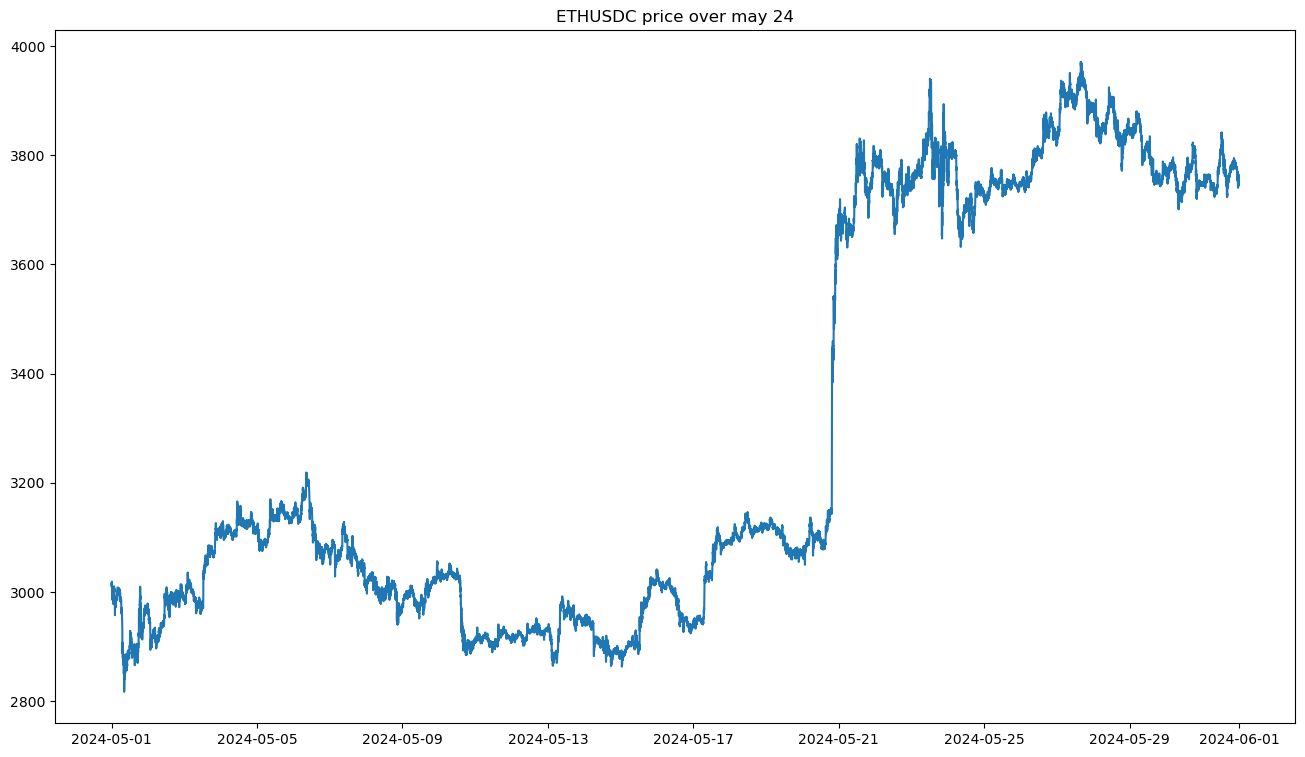

In [6]:
plt.plot(df_may.index.values, df_may['close'].values)
plt.title(pair+' price over may 24')
plt.show()

STANDARD GBM

In [7]:
df_may['log_returns'] = np.log(df_may['close'] / df_may['close'].shift(1))

trading_minutes_per_year = 365 * 24 * 60

log_return_mean = df_may['log_returns'].mean()

mu = log_return_mean * trading_minutes_per_year

log_return_variance = df_may['log_returns'].var()

vol = np.sqrt(log_return_variance * trading_minutes_per_year)

print('mu=',mu)
print('mu_daily=',mu/365)
print('sigma=',vol)
print('sigma_daily=',vol/np.sqrt(365))

mu= 2.5954406908574073
mu_daily= 0.007110796413307965
sigma= 0.6260775661260336
sigma_daily= 0.03277039755074224


HESTON MODEL

In [8]:
window_size = 60  # 1 hour window
df_may['rolling_std'] = df_may['log_returns'].rolling(window=window_size).std()
df_may['annualized_volatility'] = df_may['rolling_std'] * np.sqrt(trading_minutes_per_year)

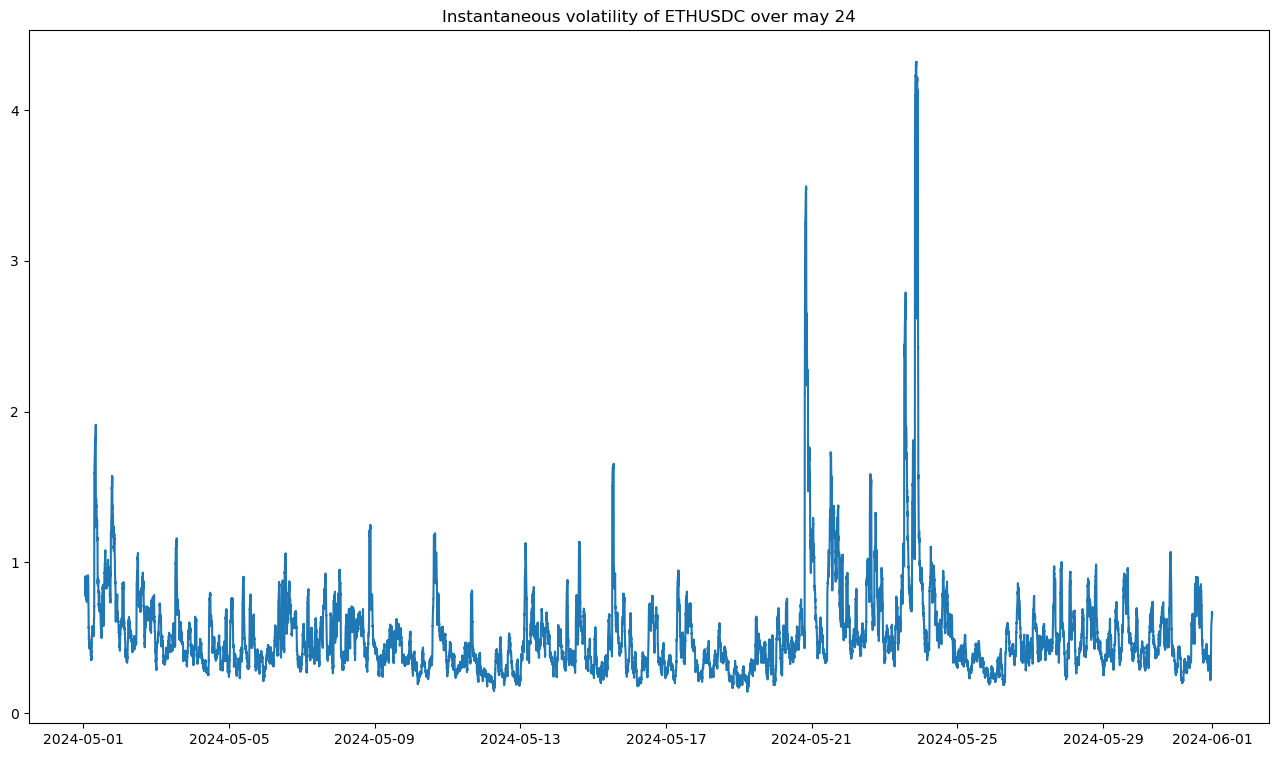

In [9]:
plt.plot(df_may.index.values, df_may['annualized_volatility'].values)
plt.title('Instantaneous volatility of '+pair+' over may 24')
plt.show()

In [10]:
from scipy.optimize import minimize

def heston_log_likelihood(params, variances, dt):
    kappa, theta, sigma = params
    log_likelihood = 0
    
    for t in range(1, len(variances)):
        vt = variances[t-1]
        vt_next = variances[t]
        mean = vt + kappa * (theta - vt) * dt
        variance = sigma**2 * vt * dt
        
        log_likelihood += -0.5 * np.log(2 * np.pi * variance) - (vt_next - mean)**2 / (2 * variance)
    
    return -log_likelihood 

In [11]:
%%time
def objective(trial):
    kappa = trial.suggest_float('kappa', 50., 10000.)
    theta = trial.suggest_float('theta', 0.01, 1.)
    sigma = trial.suggest_float('sigma', 1., 100.)
    params = kappa, theta, sigma
    
    variances = df_may.dropna()['annualized_volatility']**2
    
    dt = 1./trading_minutes_per_year
    
    return heston_log_likelihood(params, variances, dt)

study = optuna.create_study(sampler=TPESampler(seed = 0))
study.enqueue_trial({'kappa': 1000., 'theta': 0.01, 'c': 5.})
study.optimize(objective, n_trials=1000)

[I 2024-08-16 15:35:04,011] A new study created in memory with name: no-name-4365f603-ca78-4ddd-8e0a-7d3696da9cb0
[I 2024-08-16 15:35:04,188] Trial 0 finished with value: -87767.50994655045 and parameters: {'kappa': 1000.0, 'theta': 0.01, 'sigma': 55.33253688880515}. Best is trial 0 with value: -87767.50994655045.
[I 2024-08-16 15:35:04,367] Trial 1 finished with value: -86838.76097484045 and parameters: {'kappa': 7166.134195405574, 'theta': 0.6067357423109274, 'sigma': 54.94343511669279}. Best is trial 0 with value: -87767.50994655045.
[I 2024-08-16 15:35:04,545] Trial 2 finished with value: -86061.98349364442 and parameters: {'kappa': 4265.365253422102, 'theta': 0.6494351719359895, 'sigma': 44.321133915006556}. Best is trial 0 with value: -87767.50994655045.
[I 2024-08-16 15:35:04,721] Trial 3 finished with value: -74092.15747005121 and parameters: {'kappa': 8923.141357781693, 'theta': 0.964026132896019, 'sigma': 38.96071036375199}. Best is trial 0 with value: -87767.50994655045.
[I 

[I 2024-08-16 15:35:10,774] Trial 36 finished with value: -87391.7482198572 and parameters: {'kappa': 4012.3737401285744, 'theta': 0.7006629500076765, 'sigma': 50.16076244584386}. Best is trial 29 with value: -87823.8365475625.
[I 2024-08-16 15:35:10,959] Trial 37 finished with value: -82790.67664426855 and parameters: {'kappa': 848.5861983676396, 'theta': 0.5264534474495622, 'sigma': 76.37052305569455}. Best is trial 29 with value: -87823.8365475625.
[I 2024-08-16 15:35:11,143] Trial 38 finished with value: -77658.62643939444 and parameters: {'kappa': 3216.1755768069897, 'theta': 0.08579718205460879, 'sigma': 34.47310234317824}. Best is trial 29 with value: -87823.8365475625.
[I 2024-08-16 15:35:11,328] Trial 39 finished with value: -86687.63882437973 and parameters: {'kappa': 7974.343243835709, 'theta': 0.17184815424387367, 'sigma': 45.18669550852958}. Best is trial 29 with value: -87823.8365475625.
[I 2024-08-16 15:35:11,510] Trial 40 finished with value: -87394.45623536641 and para

[I 2024-08-16 15:35:17,406] Trial 72 finished with value: -87919.05412726405 and parameters: {'kappa': 752.956426853952, 'theta': 0.333511250608249, 'sigma': 51.147273843429375}. Best is trial 72 with value: -87919.05412726405.
[I 2024-08-16 15:35:17,592] Trial 73 finished with value: -87925.30314251811 and parameters: {'kappa': 1098.028434279414, 'theta': 0.4148889886896163, 'sigma': 52.727911534155425}. Best is trial 73 with value: -87925.30314251811.
[I 2024-08-16 15:35:17,779] Trial 74 finished with value: -87777.37571019077 and parameters: {'kappa': 552.8148542195631, 'theta': 0.43002181451613813, 'sigma': 55.32188249850419}. Best is trial 73 with value: -87925.30314251811.
[I 2024-08-16 15:35:17,975] Trial 75 finished with value: -86976.93005642574 and parameters: {'kappa': 481.7655591099301, 'theta': 0.3501223561440931, 'sigma': 60.74802473726864}. Best is trial 73 with value: -87925.30314251811.
[I 2024-08-16 15:35:18,165] Trial 76 finished with value: -85791.5275015702 and par

[I 2024-08-16 15:35:24,364] Trial 108 finished with value: -86402.15711835923 and parameters: {'kappa': 1555.987574344717, 'theta': 0.4695083018717147, 'sigma': 43.77766214245064}. Best is trial 84 with value: -87930.63033555746.
[I 2024-08-16 15:35:24,565] Trial 109 finished with value: -87921.68935615815 and parameters: {'kappa': 1306.7380313865692, 'theta': 0.5392776039680223, 'sigma': 52.13127781303188}. Best is trial 84 with value: -87930.63033555746.
[I 2024-08-16 15:35:24,768] Trial 110 finished with value: -87613.89122291941 and parameters: {'kappa': 434.1339344615965, 'theta': 0.4384070400450181, 'sigma': 47.963067830475836}. Best is trial 84 with value: -87930.63033555746.
[I 2024-08-16 15:35:24,970] Trial 111 finished with value: -87912.8621191618 and parameters: {'kappa': 1347.1285707284696, 'theta': 0.5883921038620404, 'sigma': 51.70212076802815}. Best is trial 84 with value: -87930.63033555746.
[I 2024-08-16 15:35:25,175] Trial 112 finished with value: -87904.45650596327 

[I 2024-08-16 15:35:31,558] Trial 144 finished with value: -87780.06735188009 and parameters: {'kappa': 443.4556056531312, 'theta': 0.5080154275419101, 'sigma': 55.29076098224601}. Best is trial 141 with value: -87932.59611438673.
[I 2024-08-16 15:35:31,753] Trial 145 finished with value: -87931.9704715171 and parameters: {'kappa': 763.9586438187537, 'theta': 0.4454341638400177, 'sigma': 52.39471608742865}. Best is trial 141 with value: -87932.59611438673.
[I 2024-08-16 15:35:31,949] Trial 146 finished with value: -87064.59658439575 and parameters: {'kappa': 705.147826844357, 'theta': 0.4521567072265702, 'sigma': 60.291772725357816}. Best is trial 141 with value: -87932.59611438673.
[I 2024-08-16 15:35:32,146] Trial 147 finished with value: -87558.74113484084 and parameters: {'kappa': 134.59588097795103, 'theta': 0.47903643852036, 'sigma': 57.22948917670677}. Best is trial 141 with value: -87932.59611438673.
[I 2024-08-16 15:35:32,342] Trial 148 finished with value: -87919.51668128281 

[I 2024-08-16 15:35:38,675] Trial 180 finished with value: -87859.17713227739 and parameters: {'kappa': 1040.9336419143592, 'theta': 0.41554531294752584, 'sigma': 54.26565939872431}. Best is trial 179 with value: -87933.60405171633.
[I 2024-08-16 15:35:38,877] Trial 181 finished with value: -87932.35071665418 and parameters: {'kappa': 693.5268266028959, 'theta': 0.4066901604779117, 'sigma': 51.77644020501805}. Best is trial 179 with value: -87933.60405171633.
[I 2024-08-16 15:35:39,077] Trial 182 finished with value: -87933.81821937268 and parameters: {'kappa': 708.800999488768, 'theta': 0.4028468612763464, 'sigma': 52.02481361936687}. Best is trial 182 with value: -87933.81821937268.
[I 2024-08-16 15:35:39,271] Trial 183 finished with value: -87932.99429817926 and parameters: {'kappa': 670.3712993783909, 'theta': 0.4039278412140501, 'sigma': 51.850044312755635}. Best is trial 182 with value: -87933.81821937268.
[I 2024-08-16 15:35:39,468] Trial 184 finished with value: -87748.56420702

[I 2024-08-16 15:35:45,879] Trial 216 finished with value: -87911.08994611773 and parameters: {'kappa': 557.3397267663798, 'theta': 0.4028814181684973, 'sigma': 50.92821870307813}. Best is trial 182 with value: -87933.81821937268.
[I 2024-08-16 15:35:46,076] Trial 217 finished with value: -87904.57913595349 and parameters: {'kappa': 81.68347007885234, 'theta': 0.4826056060534024, 'sigma': 53.36000126993852}. Best is trial 182 with value: -87933.81821937268.
[I 2024-08-16 15:35:46,273] Trial 218 finished with value: -87804.08163736042 and parameters: {'kappa': 990.32931183724, 'theta': 0.32503839462833306, 'sigma': 49.39263558061709}. Best is trial 182 with value: -87933.81821937268.
[I 2024-08-16 15:35:46,475] Trial 219 finished with value: -87832.38903674799 and parameters: {'kappa': 763.132673977045, 'theta': 0.38205000366702546, 'sigma': 54.665447450972344}. Best is trial 182 with value: -87933.81821937268.
[I 2024-08-16 15:35:46,676] Trial 220 finished with value: -87365.1759603589

[I 2024-08-16 15:35:53,116] Trial 252 finished with value: -87908.98860965253 and parameters: {'kappa': 551.0219401902183, 'theta': 0.4036239774623517, 'sigma': 50.877267335074905}. Best is trial 182 with value: -87933.81821937268.
[I 2024-08-16 15:35:53,322] Trial 253 finished with value: -87898.97898552775 and parameters: {'kappa': 358.27886512152395, 'theta': 0.37996638079771894, 'sigma': 53.54331817776481}. Best is trial 182 with value: -87933.81821937268.
[I 2024-08-16 15:35:53,525] Trial 254 finished with value: -86984.65901780385 and parameters: {'kappa': 716.3439987574008, 'theta': 0.3421704018070755, 'sigma': 45.31349307924793}. Best is trial 182 with value: -87933.81821937268.
[I 2024-08-16 15:35:53,730] Trial 255 finished with value: -87928.67593765083 and parameters: {'kappa': 277.0700208042694, 'theta': 0.4291796571267651, 'sigma': 51.61635375436174}. Best is trial 182 with value: -87933.81821937268.
[I 2024-08-16 15:35:53,935] Trial 256 finished with value: -87734.7961638

[I 2024-08-16 15:36:00,393] Trial 288 finished with value: -87929.61591646743 and parameters: {'kappa': 740.4001898753361, 'theta': 0.42575664841128325, 'sigma': 52.58563793705623}. Best is trial 279 with value: -87933.82467328761.
[I 2024-08-16 15:36:00,594] Trial 289 finished with value: -87779.64133500414 and parameters: {'kappa': 1116.298525402364, 'theta': 0.3903429094452483, 'sigma': 55.28480898916423}. Best is trial 279 with value: -87933.82467328761.
[I 2024-08-16 15:36:00,795] Trial 290 finished with value: -87810.52728666016 and parameters: {'kappa': 573.4583329213773, 'theta': 0.3523047308314076, 'sigma': 49.459127817414554}. Best is trial 279 with value: -87933.82467328761.
[I 2024-08-16 15:36:00,996] Trial 291 finished with value: -87930.75471890121 and parameters: {'kappa': 837.7547251005524, 'theta': 0.4185026124958587, 'sigma': 52.49525033114473}. Best is trial 279 with value: -87933.82467328761.
[I 2024-08-16 15:36:01,199] Trial 292 finished with value: -87515.64240708

[I 2024-08-16 15:36:07,639] Trial 324 finished with value: -87841.0817906859 and parameters: {'kappa': 253.6774044104219, 'theta': 0.3535087297791053, 'sigma': 54.51961903877173}. Best is trial 279 with value: -87933.82467328761.
[I 2024-08-16 15:36:07,838] Trial 325 finished with value: -87654.01752357997 and parameters: {'kappa': 981.6557090478489, 'theta': 0.3257853591833825, 'sigma': 56.4921140704992}. Best is trial 279 with value: -87933.82467328761.
[I 2024-08-16 15:36:08,039] Trial 326 finished with value: -87777.05126214783 and parameters: {'kappa': 738.5394719990811, 'theta': 0.54645648886925, 'sigma': 49.15006464860827}. Best is trial 279 with value: -87933.82467328761.
[I 2024-08-16 15:36:08,242] Trial 327 finished with value: -87930.41582286646 and parameters: {'kappa': 526.3008010125142, 'theta': 0.3409608860457985, 'sigma': 52.49437942984913}. Best is trial 279 with value: -87933.82467328761.
[I 2024-08-16 15:36:08,445] Trial 328 finished with value: -87879.18585377604 an

[I 2024-08-16 15:36:14,939] Trial 360 finished with value: -87840.57299896648 and parameters: {'kappa': 1644.8659694078476, 'theta': 0.43673808002521647, 'sigma': 49.93859869274203}. Best is trial 279 with value: -87933.82467328761.
[I 2024-08-16 15:36:15,142] Trial 361 finished with value: -87857.42181686233 and parameters: {'kappa': 750.8506438519294, 'theta': 0.4030360487054112, 'sigma': 54.31136758065992}. Best is trial 279 with value: -87933.82467328761.
[I 2024-08-16 15:36:15,345] Trial 362 finished with value: -87930.90126083701 and parameters: {'kappa': 509.0233134535844, 'theta': 0.3594207193715486, 'sigma': 51.701669518154716}. Best is trial 279 with value: -87933.82467328761.
[I 2024-08-16 15:36:15,549] Trial 363 finished with value: -87749.94579181497 and parameters: {'kappa': 972.6318402780994, 'theta': 0.42086670980491586, 'sigma': 48.913449428812534}. Best is trial 279 with value: -87933.82467328761.
[I 2024-08-16 15:36:15,755] Trial 364 finished with value: -87413.19710

[I 2024-08-16 15:36:22,257] Trial 396 finished with value: -87567.7293200833 and parameters: {'kappa': 404.45858079877536, 'theta': 0.3474797190831686, 'sigma': 47.70074850294598}. Best is trial 279 with value: -87933.82467328761.
[I 2024-08-16 15:36:22,460] Trial 397 finished with value: -87889.44349032306 and parameters: {'kappa': 664.3685949609892, 'theta': 0.3817208794971559, 'sigma': 50.47751264907638}. Best is trial 279 with value: -87933.82467328761.
[I 2024-08-16 15:36:22,665] Trial 398 finished with value: -87914.87734767978 and parameters: {'kappa': 834.159181752518, 'theta': 0.4045516061360797, 'sigma': 53.166824874056914}. Best is trial 279 with value: -87933.82467328761.
[I 2024-08-16 15:36:22,867] Trial 399 finished with value: -86923.59344598927 and parameters: {'kappa': 81.14931868080362, 'theta': 0.35462899678437243, 'sigma': 61.00829401517233}. Best is trial 279 with value: -87933.82467328761.
[I 2024-08-16 15:36:23,069] Trial 400 finished with value: -87766.034154490

[I 2024-08-16 15:36:29,649] Trial 432 finished with value: -87748.00628027649 and parameters: {'kappa': 1104.5945648667187, 'theta': 0.027812417714136284, 'sigma': 48.98341321742012}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:36:29,855] Trial 433 finished with value: -87906.40877174588 and parameters: {'kappa': 812.9522293446666, 'theta': 0.4137118848534406, 'sigma': 50.816533605343466}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:36:30,063] Trial 434 finished with value: -87893.75622128855 and parameters: {'kappa': 238.77778442625856, 'theta': 0.37845220909918326, 'sigma': 53.63742992530451}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:36:30,271] Trial 435 finished with value: -87540.06029358937 and parameters: {'kappa': 2911.467154383716, 'theta': 0.24993190954138006, 'sigma': 47.66224019550995}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:36:30,477] Trial 436 finished with value: -87928.550

[I 2024-08-16 15:36:37,054] Trial 468 finished with value: -87746.91008226632 and parameters: {'kappa': 404.91678122594453, 'theta': 0.41748607037772884, 'sigma': 55.63521352739293}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:36:37,258] Trial 469 finished with value: -86577.2900141326 and parameters: {'kappa': 736.9627759925918, 'theta': 0.4424973108353618, 'sigma': 62.674143246894175}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:36:37,465] Trial 470 finished with value: -87836.79709106984 and parameters: {'kappa': 565.490443203946, 'theta': 0.2901504153525384, 'sigma': 49.751707846007804}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:36:37,670] Trial 471 finished with value: -87931.14346743807 and parameters: {'kappa': 236.97446256991537, 'theta': 0.34015939659099614, 'sigma': 51.94878955688312}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:36:37,875] Trial 472 finished with value: -87867.858716

[I 2024-08-16 15:36:44,472] Trial 504 finished with value: -87821.77103574116 and parameters: {'kappa': 1263.6448463711815, 'theta': 0.42900616782219725, 'sigma': 54.755569076995684}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:36:44,684] Trial 505 finished with value: -87901.02067840364 and parameters: {'kappa': 828.4105118722609, 'theta': 0.3194653616567666, 'sigma': 50.69927934621479}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:36:44,898] Trial 506 finished with value: -87782.41690833383 and parameters: {'kappa': 554.1093473356549, 'theta': 0.3989567686914635, 'sigma': 49.186516884565535}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:36:45,105] Trial 507 finished with value: -87921.15433376966 and parameters: {'kappa': 291.54854566934836, 'theta': 0.35679493647668703, 'sigma': 52.90230925930458}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:36:45,313] Trial 508 finished with value: -87460.3656

[I 2024-08-16 15:36:51,920] Trial 540 finished with value: -53095.87372206619 and parameters: {'kappa': 486.22245104216864, 'theta': 0.3091855181141936, 'sigma': 26.263523398507413}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:36:52,128] Trial 541 finished with value: -87914.57376995336 and parameters: {'kappa': 605.073579899715, 'theta': 0.3375258699069805, 'sigma': 51.02478785052423}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:36:52,333] Trial 542 finished with value: -87876.83222985582 and parameters: {'kappa': 197.02782974749005, 'theta': 0.3772376003853547, 'sigma': 53.95600667811165}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:36:52,539] Trial 543 finished with value: -87493.41036204102 and parameters: {'kappa': 1084.1721522452353, 'theta': 0.35973092324337, 'sigma': 47.30562162964888}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:36:52,745] Trial 544 finished with value: -87753.102165580

[I 2024-08-16 15:36:59,405] Trial 576 finished with value: -87921.45641233567 and parameters: {'kappa': 955.5623819381275, 'theta': 0.35239376707117304, 'sigma': 52.95178800213692}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:36:59,614] Trial 577 finished with value: -87615.23636571047 and parameters: {'kappa': 160.90138592846802, 'theta': 0.4920182016886325, 'sigma': 56.7951936294057}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:36:59,822] Trial 578 finished with value: -87911.57489773096 and parameters: {'kappa': 735.6966988549664, 'theta': 0.3676513022408916, 'sigma': 50.935516506232794}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:00,031] Trial 579 finished with value: -87760.20750016981 and parameters: {'kappa': 4428.301766269217, 'theta': 0.40442445160162643, 'sigma': 53.80215087791586}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:00,243] Trial 580 finished with value: -87562.8458896

[I 2024-08-16 15:37:06,938] Trial 612 finished with value: -87666.09853277158 and parameters: {'kappa': 5223.480708586694, 'theta': 0.3846777832271384, 'sigma': 54.73182195210047}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:07,146] Trial 613 finished with value: -87890.15222026705 and parameters: {'kappa': 903.507712737199, 'theta': 0.3210830464501333, 'sigma': 50.491971904433065}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:07,354] Trial 614 finished with value: -87916.09703275198 and parameters: {'kappa': 339.0403911287164, 'theta': 0.36704062225482603, 'sigma': 53.09145071973416}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:07,560] Trial 615 finished with value: -87622.37983762236 and parameters: {'kappa': 706.7169414271356, 'theta': 0.5385591481502272, 'sigma': 48.018049160464116}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:07,767] Trial 616 finished with value: -87831.44423383

[I 2024-08-16 15:37:14,446] Trial 648 finished with value: -82891.46392557267 and parameters: {'kappa': 702.7786156631362, 'theta': 0.4474348056851183, 'sigma': 76.05028328891268}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:14,659] Trial 649 finished with value: -87921.32732994056 and parameters: {'kappa': 1557.8078442508504, 'theta': 0.44384017371611084, 'sigma': 52.465534459359816}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:14,870] Trial 650 finished with value: -87856.20244927566 and parameters: {'kappa': 633.7813578508277, 'theta': 0.46916431612315884, 'sigma': 49.979622611923254}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:15,083] Trial 651 finished with value: -87860.30634443914 and parameters: {'kappa': 260.94825776570394, 'theta': 0.42763767032288214, 'sigma': 54.24278737846591}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:15,294] Trial 652 finished with value: -87929.660

[I 2024-08-16 15:37:22,203] Trial 684 finished with value: -87834.77839248549 and parameters: {'kappa': 784.4643897404198, 'theta': 0.3259563431417034, 'sigma': 49.717987790770536}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:22,419] Trial 685 finished with value: -87777.58825578493 and parameters: {'kappa': 1769.6169093953354, 'theta': 0.4800089781072948, 'sigma': 55.118971896975644}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:22,640] Trial 686 finished with value: -87930.6366958112 and parameters: {'kappa': 454.92575666634093, 'theta': 0.2984570428258533, 'sigma': 51.743149324285966}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:22,862] Trial 687 finished with value: -87321.33165799777 and parameters: {'kappa': 198.4283468039481, 'theta': 0.392490440060268, 'sigma': 58.82297504923356}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:23,082] Trial 688 finished with value: -87887.0673726

[I 2024-08-16 15:37:30,172] Trial 720 finished with value: -87407.54380466625 and parameters: {'kappa': 679.0567659940343, 'theta': 0.35955904735629657, 'sigma': 46.894457110808474}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:30,398] Trial 721 finished with value: -87793.2706018543 and parameters: {'kappa': 484.3284876171563, 'theta': 0.29510765591507987, 'sigma': 55.13315570165848}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:30,623] Trial 722 finished with value: -87926.51473089687 and parameters: {'kappa': 274.15511433380493, 'theta': 0.3351125394161123, 'sigma': 52.64735205896415}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:30,850] Trial 723 finished with value: -87852.20908936932 and parameters: {'kappa': 963.4505486321102, 'theta': 0.48784590427970026, 'sigma': 49.96074504832165}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:31,079] Trial 724 finished with value: -87885.089334

[I 2024-08-16 15:37:38,767] Trial 756 finished with value: -87706.53997393917 and parameters: {'kappa': 829.7715559021365, 'theta': 0.495964028291841, 'sigma': 48.5805871018574}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:39,024] Trial 757 finished with value: -87795.3052103907 and parameters: {'kappa': 2393.178915236038, 'theta': 0.3341041348062096, 'sigma': 54.9453079091675}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:39,267] Trial 758 finished with value: -87900.06390287797 and parameters: {'kappa': 354.82841560678537, 'theta': 0.3802920974782699, 'sigma': 50.70456686798602}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:39,505] Trial 759 finished with value: -87921.39965220394 and parameters: {'kappa': 579.9597753469402, 'theta': 0.4713611012550035, 'sigma': 52.95823918916932}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:39,742] Trial 760 finished with value: -87701.15071136209 a

[I 2024-08-16 15:37:47,575] Trial 792 finished with value: -87933.3444218919 and parameters: {'kappa': 593.3428895728123, 'theta': 0.4105694479566249, 'sigma': 52.240269173155276}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:47,822] Trial 793 finished with value: -87505.06316668543 and parameters: {'kappa': 571.8355480371989, 'theta': 0.380966918002943, 'sigma': 47.36144458835312}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:48,071] Trial 794 finished with value: -87932.51687452378 and parameters: {'kappa': 1069.3254996410087, 'theta': 0.40004786850343754, 'sigma': 52.153259877770736}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:48,335] Trial 795 finished with value: -86553.16495464846 and parameters: {'kappa': 4625.560849260184, 'theta': 0.4098217159950486, 'sigma': 44.66088076195375}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:48,610] Trial 796 finished with value: -87893.57512953

[I 2024-08-16 15:37:56,751] Trial 828 finished with value: -87923.90735353083 and parameters: {'kappa': 711.5793049145672, 'theta': 0.37050169328695814, 'sigma': 51.310487855742224}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:57,006] Trial 829 finished with value: -87692.36334197833 and parameters: {'kappa': 511.10128468176003, 'theta': 0.4098320525387739, 'sigma': 48.47081108526588}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:57,266] Trial 830 finished with value: -87877.58282815265 and parameters: {'kappa': 1032.1016359104651, 'theta': 0.3957843841804581, 'sigma': 53.96969778908232}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:57,524] Trial 831 finished with value: -87881.99204802045 and parameters: {'kappa': 328.06316792882427, 'theta': 0.42576359674777836, 'sigma': 50.37237688866031}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:37:57,781] Trial 832 finished with value: -87174.5040

[I 2024-08-16 15:38:06,264] Trial 864 finished with value: -87932.72362853104 and parameters: {'kappa': 465.45445471198593, 'theta': 0.44817761936750045, 'sigma': 52.29844108573829}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:38:06,537] Trial 865 finished with value: -87799.60971863485 and parameters: {'kappa': 1377.0226713440088, 'theta': 0.5027876570759108, 'sigma': 49.46746360999887}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:38:06,816] Trial 866 finished with value: -87777.67426240123 and parameters: {'kappa': 208.13725657364057, 'theta': 0.40128059650803694, 'sigma': 55.297048510167215}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:38:07,089] Trial 867 finished with value: -87531.80434855967 and parameters: {'kappa': 679.9522089752887, 'theta': 0.30250471520325023, 'sigma': 47.50133709732082}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:38:07,360] Trial 868 finished with value: -87874.348

[I 2024-08-16 15:38:16,212] Trial 900 finished with value: -87762.12605209433 and parameters: {'kappa': 966.6786704655683, 'theta': 0.29394988565910357, 'sigma': 49.009012069942756}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:38:16,496] Trial 901 finished with value: -87271.63002583905 and parameters: {'kappa': 8484.242690709349, 'theta': 0.42458728179364175, 'sigma': 52.0348669367489}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:38:16,781] Trial 902 finished with value: -87838.13369023147 and parameters: {'kappa': 623.3173868238943, 'theta': 0.458825064705997, 'sigma': 54.58729043158074}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:38:17,066] Trial 903 finished with value: -87885.38579848436 and parameters: {'kappa': 748.0040459069903, 'theta': 0.3948476536532586, 'sigma': 50.40713312455224}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:38:17,349] Trial 904 finished with value: -87931.663705386

[I 2024-08-16 15:38:26,724] Trial 936 finished with value: -87886.24742178553 and parameters: {'kappa': 357.9381445037267, 'theta': 0.4716693727880622, 'sigma': 50.43615831656987}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:38:27,013] Trial 937 finished with value: -87660.4179737009 and parameters: {'kappa': 6101.415917724316, 'theta': 0.2531559481670641, 'sigma': 55.40746599637665}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:38:27,301] Trial 938 finished with value: -87933.36063499853 and parameters: {'kappa': 731.9674929734047, 'theta': 0.3255523534273686, 'sigma': 52.215878900443776}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:38:27,589] Trial 939 finished with value: -87917.4399530765 and parameters: {'kappa': 1369.7014579180159, 'theta': 0.3031280941455327, 'sigma': 53.044249596574254}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:38:27,875] Trial 940 finished with value: -87264.245106640

[I 2024-08-16 15:38:37,261] Trial 972 finished with value: -87879.7226129376 and parameters: {'kappa': 585.6735681616663, 'theta': 0.35826946444996266, 'sigma': 50.3202711291397}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:38:37,556] Trial 973 finished with value: -87612.45525001618 and parameters: {'kappa': 294.7091669238467, 'theta': 0.3922120987409491, 'sigma': 47.96248545819264}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:38:37,849] Trial 974 finished with value: -87571.95659306648 and parameters: {'kappa': 752.9398018540895, 'theta': 0.4292577424373745, 'sigma': 57.147042315310856}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:38:38,147] Trial 975 finished with value: -87670.42378875452 and parameters: {'kappa': 7496.588583599922, 'theta': 0.30562418298817634, 'sigma': 53.0631259087668}. Best is trial 403 with value: -87933.84400437042.
[I 2024-08-16 15:38:38,443] Trial 976 finished with value: -87615.5807437294

CPU times: user 3min 40s, sys: 374 ms, total: 3min 40s
Wall time: 3min 41s


In [12]:
study.best_params

{'kappa': 751.0219938629164,
 'theta': 0.3890223269746,
 'sigma': 52.11383590194372}

CALIBRATION ON DATA FROM JUNE 24


In [ ]:
df_06 = pd.read_csv('../data/'+pair+'/'+pair+'-1m-2024-06.csv')
df_06.columns=['time', 'open', 'high', 'low', 'close', 's1', 's2', 's3', 's4', 's5', 's6', 's7']
df_06.set_index('time', inplace=True)
df_06.index = pd.to_datetime(df_06.index, unit='ms')
df_06

,open,high,low,close,s1,s2,s3,s4,s5,s6,s7
time,,,,,,,,,,,
2024-06-01 00:01:00,3762.43,3762.43,3762.43,3762.43,0.0000,1717200119999,0.000000,0,0.0000,0.000000,0
2024-06-01 00:02:00,3759.41,3761.41,3759.41,3760.91,0.7600,1717200179999,2858.490700,6,0.0954,358.657614,0
2024-06-01 00:03:00,3760.80,3764.64,3759.60,3762.20,13.2412,1717200239999,49827.831455,61,10.2637,38625.181622,0
2024-06-01 00:04:00,3761.73,3765.53,3761.73,3762.96,38.8119,1717200299999,146083.076078,53,36.3503,136819.211605,0
2024-06-01 00:05:00,3762.60,3763.80,3762.60,3763.27,3.4958,1717200359999,13156.142840,16,1.9712,7418.032718,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30 23:55:00,3436.62,3436.62,3436.62,3436.62,0.0961,1719791759999,330.259182,2,0.0961,330.259182,0
2024-06-30 23:56:00,3437.09,3437.09,3434.80,3434.80,2.9474,1719791819999,10125.844309,30,0.0888,305.213592,0
2024-06-30 23:57:00,3435.16,3435.38,3435.16,3435.31,0.1892,1719791879999,649.948144,4,0.0888,305.042208,0


In [14]:
df_june = df_06[['close']].copy()
df_june

,close
time,
2024-06-01 00:01:00,3762.43
2024-06-01 00:02:00,3760.91
2024-06-01 00:03:00,3762.20
2024-06-01 00:04:00,3762.96
2024-06-01 00:05:00,3763.27
...,...
2024-06-30 23:55:00,3436.62
2024-06-30 23:56:00,3434.80
2024-06-30 23:57:00,3435.31


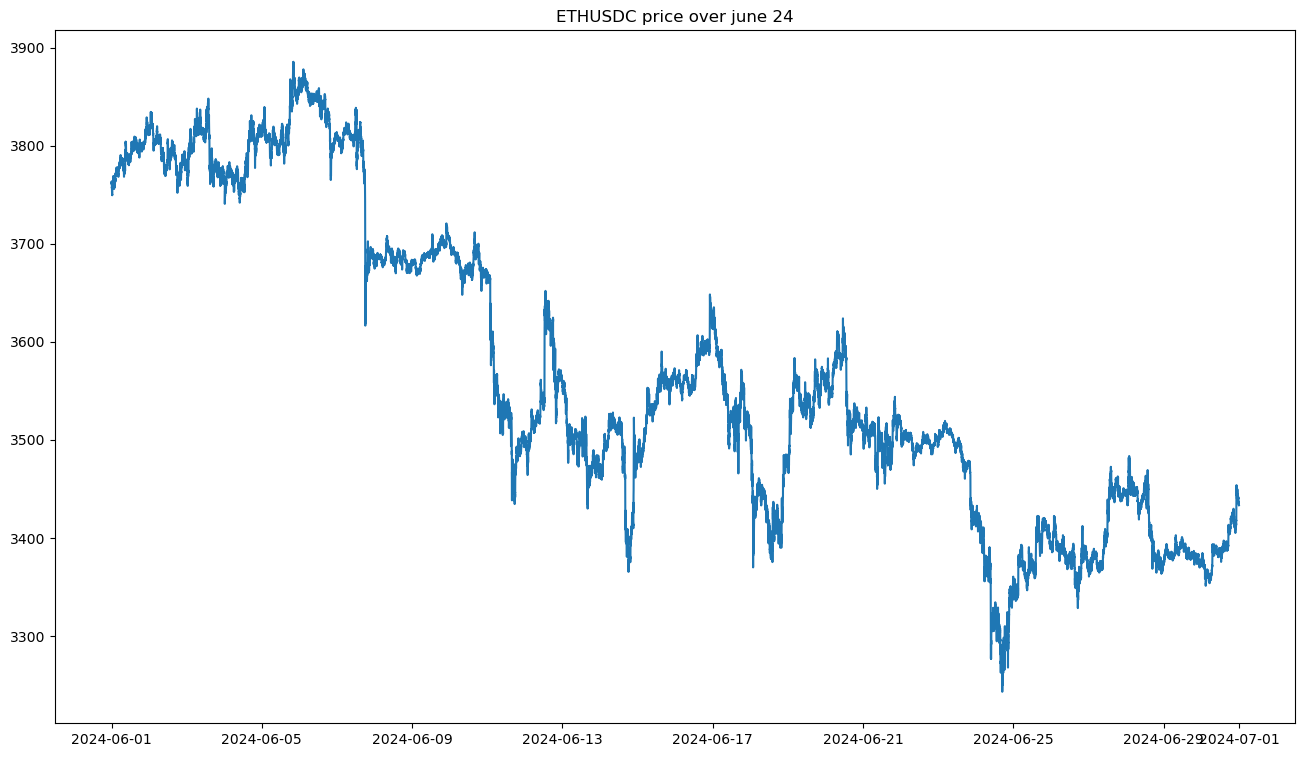

In [15]:
plt.plot(df_june.index.values, df_june['close'].values)
plt.title(pair+' price over june 24')
plt.show()

STANDARD GBM

In [16]:
df_june['log_returns'] = np.log(df_june['close'] / df_june['close'].shift(1))

trading_minutes_per_year = 365 * 24 * 60

log_return_mean = df_june['log_returns'].mean()

mu = log_return_mean * trading_minutes_per_year

log_return_variance = df_june['log_returns'].var()

vol = np.sqrt(log_return_variance * trading_minutes_per_year)

print('mu=',mu)
print('mu_daily=',mu/365)
print('sigma=',vol)
print('sigma_daily=',vol/np.sqrt(365))

mu= -1.1142161174650218
mu_daily= -0.0030526468971644434
sigma= 0.4563135551803073
sigma_daily= 0.02388454309835624


HESTON MODEL

In [17]:
window_size = 60  # 1 hour window
df_june['rolling_std'] = df_june['log_returns'].rolling(window=window_size).std()
df_june['annualized_volatility'] = df_june['rolling_std'] * np.sqrt(trading_minutes_per_year)

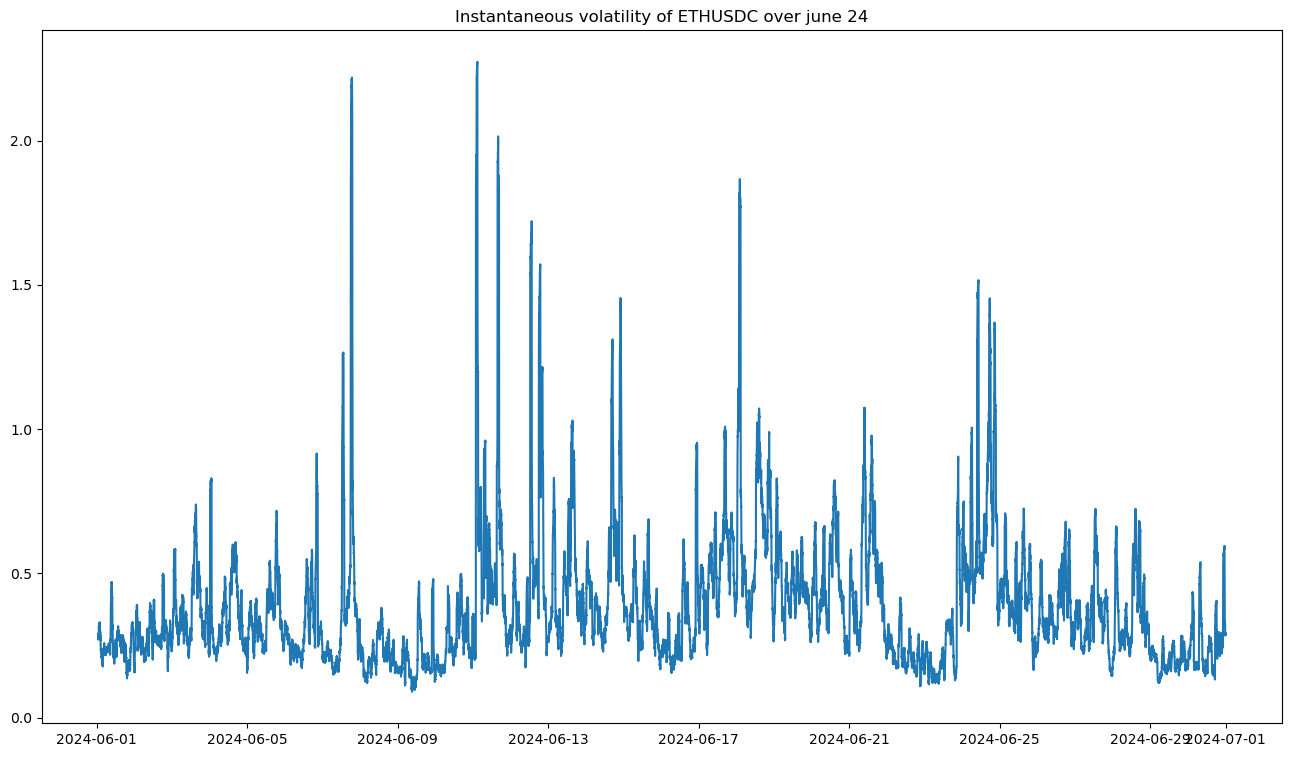

In [18]:
plt.plot(df_june.index.values, df_june['annualized_volatility'].values)
plt.title('Instantaneous volatility of '+pair+' over june 24')
plt.show()

In [19]:
%%time
def objective(trial):
    kappa = trial.suggest_float('kappa', 50., 10000.)
    theta = trial.suggest_float('theta', 0.01, 1.)
    sigma = trial.suggest_float('sigma', 1., 100.)
    params = kappa, theta, sigma
    
    variances = df_june.dropna()['annualized_volatility']**2
    
    dt = 1./trading_minutes_per_year
    
    return heston_log_likelihood(params, variances, dt)

study = optuna.create_study(sampler=TPESampler(seed = 0))
study.enqueue_trial({'kappa': 1000., 'theta': 0.01, 'c': 5.})
study.optimize(objective, n_trials=1000)

[I 2024-08-16 15:38:45,765] A new study created in memory with name: no-name-d0d7b556-f2f2-45d0-8a63-f1edd454e8e2
[I 2024-08-16 15:38:46,046] Trial 0 finished with value: -99991.63534730114 and parameters: {'kappa': 1000.0, 'theta': 0.01, 'sigma': 55.33253688880515}. Best is trial 0 with value: -99991.63534730114.
[I 2024-08-16 15:38:46,321] Trial 1 finished with value: -97640.02871966158 and parameters: {'kappa': 7166.134195405574, 'theta': 0.6067357423109274, 'sigma': 54.94343511669279}. Best is trial 0 with value: -99991.63534730114.
[I 2024-08-16 15:38:46,601] Trial 2 finished with value: -98282.97733615797 and parameters: {'kappa': 4265.365253422102, 'theta': 0.6494351719359895, 'sigma': 44.321133915006556}. Best is trial 0 with value: -99991.63534730114.
[I 2024-08-16 15:38:46,877] Trial 3 finished with value: -75936.99318798512 and parameters: {'kappa': 8923.141357781693, 'theta': 0.964026132896019, 'sigma': 38.96071036375199}. Best is trial 0 with value: -99991.63534730114.
[I 

[I 2024-08-16 15:38:56,796] Trial 36 finished with value: -95120.15949377407 and parameters: {'kappa': 5531.03530019863, 'theta': 0.6513872085480529, 'sigma': 71.14223632781224}. Best is trial 22 with value: -100402.78783500251.
[I 2024-08-16 15:38:57,102] Trial 37 finished with value: -99461.202077107 and parameters: {'kappa': 841.3260819214745, 'theta': 0.2056142395382136, 'sigma': 58.44782064010516}. Best is trial 22 with value: -100402.78783500251.
[I 2024-08-16 15:38:57,400] Trial 38 finished with value: -100387.87206039432 and parameters: {'kappa': 1861.3448566512334, 'theta': 0.10569971744849424, 'sigma': 51.24429567992011}. Best is trial 22 with value: -100402.78783500251.
[I 2024-08-16 15:38:57,697] Trial 39 finished with value: -91372.23229491992 and parameters: {'kappa': 555.143403351497, 'theta': 0.08358078370947063, 'sigma': 85.73546340605748}. Best is trial 22 with value: -100402.78783500251.
[I 2024-08-16 15:38:57,993] Trial 40 finished with value: -98105.29518028854 and

[I 2024-08-16 15:39:07,384] Trial 72 finished with value: -100138.63411546823 and parameters: {'kappa': 904.5972704934247, 'theta': 0.2239835551807873, 'sigma': 54.27666040751242}. Best is trial 71 with value: -100411.70360344395.
[I 2024-08-16 15:39:07,684] Trial 73 finished with value: -100368.00396431086 and parameters: {'kappa': 58.89015949680709, 'theta': 0.2601134217661604, 'sigma': 51.62256123007012}. Best is trial 71 with value: -100411.70360344395.
[I 2024-08-16 15:39:07,986] Trial 74 finished with value: -98758.99126062056 and parameters: {'kappa': 645.378879818972, 'theta': 0.3019795685394853, 'sigma': 61.63621832378887}. Best is trial 71 with value: -100411.70360344395.
[I 2024-08-16 15:39:08,345] Trial 75 finished with value: -100110.1035192335 and parameters: {'kappa': 347.69936746652775, 'theta': 0.18041691181313843, 'sigma': 46.05636596333988}. Best is trial 71 with value: -100411.70360344395.
[I 2024-08-16 15:39:08,705] Trial 76 finished with value: -96537.8904637959 a

[I 2024-08-16 15:39:19,028] Trial 108 finished with value: -100412.7352757373 and parameters: {'kappa': 912.3496662851308, 'theta': 0.07115307000415208, 'sigma': 49.810348496242945}. Best is trial 108 with value: -100412.7352757373.
[I 2024-08-16 15:39:19,332] Trial 109 finished with value: -98988.94754461167 and parameters: {'kappa': 962.8034058749568, 'theta': 0.06550441272368387, 'sigma': 42.10988466150111}. Best is trial 108 with value: -100412.7352757373.
[I 2024-08-16 15:39:19,634] Trial 110 finished with value: -95146.82257199187 and parameters: {'kappa': 847.1447787167181, 'theta': 0.10685071999106963, 'sigma': 36.54275530563184}. Best is trial 108 with value: -100412.7352757373.
[I 2024-08-16 15:39:19,935] Trial 111 finished with value: -100409.25501274025 and parameters: {'kappa': 1275.9852297763193, 'theta': 0.03200546406770336, 'sigma': 50.08228351837781}. Best is trial 108 with value: -100412.7352757373.
[I 2024-08-16 15:39:20,241] Trial 112 finished with value: -100307.56

[I 2024-08-16 15:39:30,366] Trial 144 finished with value: -100089.99140416217 and parameters: {'kappa': 694.765252263959, 'theta': 0.15956268650552763, 'sigma': 54.655170411528076}. Best is trial 141 with value: -100412.78720950123.
[I 2024-08-16 15:39:30,672] Trial 145 finished with value: -100028.5249876522 and parameters: {'kappa': 892.521413641682, 'theta': 0.1397972845572807, 'sigma': 45.58798441837534}. Best is trial 141 with value: -100412.78720950123.
[I 2024-08-16 15:39:30,991] Trial 146 finished with value: -100398.64609352837 and parameters: {'kappa': 191.9620940019293, 'theta': 0.10548329693454157, 'sigma': 49.100006915698216}. Best is trial 141 with value: -100412.78720950123.
[I 2024-08-16 15:39:31,304] Trial 147 finished with value: -100253.67976522853 and parameters: {'kappa': 463.65283971333264, 'theta': 0.06449296200087815, 'sigma': 53.172857087631236}. Best is trial 141 with value: -100412.78720950123.
[I 2024-08-16 15:39:31,620] Trial 148 finished with value: -9945

[I 2024-08-16 15:39:41,502] Trial 180 finished with value: -99867.5271984602 and parameters: {'kappa': 50.737274922446375, 'theta': 0.1847584279701653, 'sigma': 44.85094324427746}. Best is trial 174 with value: -100413.20183394664.
[I 2024-08-16 15:39:41,811] Trial 181 finished with value: -100413.00528580428 and parameters: {'kappa': 254.5850781739141, 'theta': 0.13414239789899715, 'sigma': 49.90666590807407}. Best is trial 174 with value: -100413.20183394664.
[I 2024-08-16 15:39:42,113] Trial 182 finished with value: -100404.92953604668 and parameters: {'kappa': 187.7840051194256, 'theta': 0.15206739460420116, 'sigma': 49.3095078768105}. Best is trial 174 with value: -100413.20183394664.
[I 2024-08-16 15:39:42,414] Trial 183 finished with value: -100358.02696768276 and parameters: {'kappa': 399.6893192082905, 'theta': 0.1363964511760238, 'sigma': 51.832887525848754}. Best is trial 174 with value: -100413.20183394664.
[I 2024-08-16 15:39:42,716] Trial 184 finished with value: -100326.

[I 2024-08-16 15:39:52,215] Trial 216 finished with value: -100226.04886753077 and parameters: {'kappa': 8371.3924093669, 'theta': 0.09461808098711869, 'sigma': 52.27322111008841}. Best is trial 197 with value: -100414.03595744602.
[I 2024-08-16 15:39:52,499] Trial 217 finished with value: -100135.80553079321 and parameters: {'kappa': 952.0737245218099, 'theta': 0.14019305363135032, 'sigma': 46.201154070667265}. Best is trial 197 with value: -100414.03595744602.
[I 2024-08-16 15:39:52,786] Trial 218 finished with value: -99526.59124039496 and parameters: {'kappa': 713.5267181986226, 'theta': 0.11271017311977757, 'sigma': 43.58099012332284}. Best is trial 197 with value: -100414.03595744602.
[I 2024-08-16 15:39:53,073] Trial 219 finished with value: -100409.53033643903 and parameters: {'kappa': 316.15515877563195, 'theta': 0.08826566368155461, 'sigma': 49.55334909877254}. Best is trial 197 with value: -100414.03595744602.
[I 2024-08-16 15:39:53,358] Trial 220 finished with value: -10038

[I 2024-08-16 15:40:02,519] Trial 252 finished with value: -100093.17504748511 and parameters: {'kappa': 1464.8099863290247, 'theta': 0.21676285930507022, 'sigma': 45.94501765414457}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:02,799] Trial 253 finished with value: -100367.95270621538 and parameters: {'kappa': 1209.8906362311557, 'theta': 0.1970965121946204, 'sigma': 51.713251735120025}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:03,079] Trial 254 finished with value: -100409.5206376494 and parameters: {'kappa': 1347.4308043018202, 'theta': 0.18616729037581103, 'sigma': 49.31565733095262}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:03,358] Trial 255 finished with value: -99843.776445576 and parameters: {'kappa': 1614.9477656906863, 'theta': 0.26236916021870244, 'sigma': 44.75470026005151}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:03,635] Trial 256 finished with value: -100242.4

[I 2024-08-16 15:40:12,526] Trial 288 finished with value: -100406.30089906794 and parameters: {'kappa': 1793.219170616333, 'theta': 0.19502510508101747, 'sigma': 50.69115363325497}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:12,834] Trial 289 finished with value: -99571.11984414696 and parameters: {'kappa': 2442.1500453966974, 'theta': 0.1741147216964197, 'sigma': 57.85687908124643}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:13,133] Trial 290 finished with value: -100400.25385541568 and parameters: {'kappa': 1432.142663276882, 'theta': 0.2203638601853506, 'sigma': 49.034537424764245}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:13,413] Trial 291 finished with value: -100176.47409053505 and parameters: {'kappa': 1266.7470624961948, 'theta': 0.16432604329962222, 'sigma': 46.461150796604755}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:13,686] Trial 292 finished with value: -100318.

[I 2024-08-16 15:40:22,322] Trial 324 finished with value: -100114.42270917182 and parameters: {'kappa': 1420.3212962935236, 'theta': 0.15855936390000086, 'sigma': 46.063733164321604}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:22,587] Trial 325 finished with value: -100077.4026594444 and parameters: {'kappa': 945.7613700822012, 'theta': 0.21571215526444937, 'sigma': 54.76112973225129}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:22,856] Trial 326 finished with value: -88027.76197671611 and parameters: {'kappa': 1110.5835351503229, 'theta': 0.1363154101050016, 'sigma': 95.84972344735263}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:23,121] Trial 327 finished with value: -100362.5870010821 and parameters: {'kappa': 1240.8337841409634, 'theta': 0.18234583446647928, 'sigma': 48.24506477777723}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:23,388] Trial 328 finished with value: -100379.0

[I 2024-08-16 15:40:31,990] Trial 360 finished with value: -99959.96350370653 and parameters: {'kappa': 1430.8487196128503, 'theta': 0.18749074291303613, 'sigma': 55.59460126940757}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:32,259] Trial 361 finished with value: -100402.15256901315 and parameters: {'kappa': 1092.4516440801901, 'theta': 0.20839971131255572, 'sigma': 50.928071606337404}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:32,527] Trial 362 finished with value: -100283.21070035563 and parameters: {'kappa': 1264.769722052396, 'theta': 0.18388174157270581, 'sigma': 52.89479978607783}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:32,795] Trial 363 finished with value: -100349.12961203538 and parameters: {'kappa': 1501.991300307016, 'theta': 0.21800671704427607, 'sigma': 48.07486993919517}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:33,062] Trial 364 finished with value: -100416

[I 2024-08-16 15:40:41,492] Trial 396 finished with value: -100358.99526050137 and parameters: {'kappa': 1473.1602184318965, 'theta': 0.18528540812161481, 'sigma': 48.19818869347445}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:41,754] Trial 397 finished with value: -100358.04172722144 and parameters: {'kappa': 1089.4995649614589, 'theta': 0.1855958195147909, 'sigma': 51.88555863481}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:42,017] Trial 398 finished with value: -99254.16677238242 and parameters: {'kappa': 3690.4271441783567, 'theta': 0.22917372553777737, 'sigma': 42.96925711563452}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:42,281] Trial 399 finished with value: -100416.4382773071 and parameters: {'kappa': 1300.967838336126, 'theta': 0.20656755293647813, 'sigma': 49.79021484169285}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:42,547] Trial 400 finished with value: -100253.7693

[I 2024-08-16 15:40:51,043] Trial 432 finished with value: -100324.08753592308 and parameters: {'kappa': 1260.7964480406463, 'theta': 0.18788197097428683, 'sigma': 47.7376771659018}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:51,312] Trial 433 finished with value: -100132.35483976454 and parameters: {'kappa': 1502.4638853251893, 'theta': 0.2097114371940348, 'sigma': 54.319040458952244}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:51,577] Trial 434 finished with value: -100417.13678146976 and parameters: {'kappa': 1324.024957771873, 'theta': 0.18785832887883164, 'sigma': 50.03597376281072}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:51,843] Trial 435 finished with value: -100326.64986265161 and parameters: {'kappa': 1246.3948358228358, 'theta': 0.18271987277392426, 'sigma': 52.355273554400036}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:40:52,115] Trial 436 finished with value: -10010

[I 2024-08-16 15:41:00,661] Trial 468 finished with value: -100188.51421132982 and parameters: {'kappa': 1713.6305852370897, 'theta': 0.2008380061290009, 'sigma': 53.829574278822825}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:00,942] Trial 469 finished with value: -99719.78434864403 and parameters: {'kappa': 2171.4561036723094, 'theta': 0.1703847020860191, 'sigma': 44.25198688145944}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:01,212] Trial 470 finished with value: -100348.18117933115 and parameters: {'kappa': 1215.6615923759296, 'theta': 0.5845767612716537, 'sigma': 48.97180043755351}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:01,478] Trial 471 finished with value: -100364.83811879203 and parameters: {'kappa': 1474.2904990322886, 'theta': 0.1992651488631753, 'sigma': 51.756192977756115}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:01,744] Trial 472 finished with value: -100123.

[I 2024-08-16 15:41:10,248] Trial 504 finished with value: -98062.83524272303 and parameters: {'kappa': 1598.0250123921328, 'theta': 0.2262046968574617, 'sigma': 40.242429699152176}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:10,515] Trial 505 finished with value: -98964.82827423565 and parameters: {'kappa': 774.2080469429585, 'theta': 0.2545702701105035, 'sigma': 60.760201826685886}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:10,782] Trial 506 finished with value: -100417.04496120822 and parameters: {'kappa': 1123.3033217380005, 'theta': 0.1737001463633105, 'sigma': 50.08461502003668}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:11,051] Trial 507 finished with value: -100192.45403756367 and parameters: {'kappa': 1059.1466648257185, 'theta': 0.13876354632493143, 'sigma': 46.57931009145356}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:11,319] Trial 508 finished with value: -100415.2

[I 2024-08-16 15:41:19,935] Trial 540 finished with value: -71645.59261775728 and parameters: {'kappa': 1220.23205305059, 'theta': 0.2009376678290649, 'sigma': 26.263523398507413}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:20,202] Trial 541 finished with value: -100342.26327729705 and parameters: {'kappa': 705.7295253719735, 'theta': 0.26657191478311754, 'sigma': 52.131402310750794}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:20,469] Trial 542 finished with value: -100410.6154723824 and parameters: {'kappa': 1428.9629808408245, 'theta': 0.15892542248929895, 'sigma': 50.588232058372945}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:20,737] Trial 543 finished with value: -100334.56542180592 and parameters: {'kappa': 1020.955891659436, 'theta': 0.1311377946489397, 'sigma': 47.8789730186655}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:21,005] Trial 544 finished with value: -100223.576

[I 2024-08-16 15:41:29,652] Trial 576 finished with value: -100123.74632052267 and parameters: {'kappa': 1150.9611751000868, 'theta': 0.17887576092396493, 'sigma': 54.397803592382246}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:29,917] Trial 577 finished with value: -100280.72898024372 and parameters: {'kappa': 1471.690572844555, 'theta': 0.2184656527806341, 'sigma': 47.303485287501076}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:30,184] Trial 578 finished with value: -100416.10336674664 and parameters: {'kappa': 1064.8523542076925, 'theta': 0.1338459204017889, 'sigma': 50.06549446010729}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:30,451] Trial 579 finished with value: -100292.17907725676 and parameters: {'kappa': 5802.236371021224, 'theta': 0.1816081706320082, 'sigma': 48.80397416671814}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:30,720] Trial 580 finished with value: -100296.

[I 2024-08-16 15:41:39,410] Trial 612 finished with value: -100097.68436956032 and parameters: {'kappa': 704.7711926113587, 'theta': 0.18874573920319324, 'sigma': 45.96750334844382}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:39,680] Trial 613 finished with value: -100402.46898650698 and parameters: {'kappa': 1259.3763348773443, 'theta': 0.21438836000254066, 'sigma': 50.9055583706964}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:39,949] Trial 614 finished with value: -100396.0700478324 and parameters: {'kappa': 1027.4844146380537, 'theta': 0.13362029366630004, 'sigma': 48.91523984944904}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:40,216] Trial 615 finished with value: -100202.1747625986 and parameters: {'kappa': 2977.7110177136387, 'theta': 0.24551877132603406, 'sigma': 53.416160247934}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:40,483] Trial 616 finished with value: -100280.858

[I 2024-08-16 15:41:49,163] Trial 648 finished with value: -100386.09406892683 and parameters: {'kappa': 735.5117153813458, 'theta': 0.12833529381959802, 'sigma': 51.30394968759184}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:49,433] Trial 649 finished with value: -100055.57527956249 and parameters: {'kappa': 936.6961033007144, 'theta': 0.14810278668549517, 'sigma': 45.73036206131724}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:49,704] Trial 650 finished with value: -99787.93423921983 and parameters: {'kappa': 442.5331372767992, 'theta': 0.13421085505150357, 'sigma': 56.6614719840276}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:49,977] Trial 651 finished with value: -100414.19261102602 and parameters: {'kappa': 655.275073899591, 'theta': 0.10527029339131436, 'sigma': 49.912102219368194}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:50,250] Trial 652 finished with value: -100145.158

[I 2024-08-16 15:41:58,836] Trial 684 finished with value: -100413.75112461421 and parameters: {'kappa': 371.5203433633578, 'theta': 0.1346944746976342, 'sigma': 50.02565590166187}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:59,105] Trial 685 finished with value: -100411.08996757651 and parameters: {'kappa': 1026.2772180690647, 'theta': 0.14893528555010946, 'sigma': 49.41332120032761}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:59,372] Trial 686 finished with value: -100150.63630592138 and parameters: {'kappa': 770.5821924293093, 'theta': 0.09598849189650813, 'sigma': 46.311213249784075}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:59,638] Trial 687 finished with value: -99822.31926826829 and parameters: {'kappa': 1310.1992531622022, 'theta': 0.12593884129362642, 'sigma': 56.465333113701504}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:41:59,904] Trial 688 finished with value: -100368

[I 2024-08-16 15:42:08,543] Trial 720 finished with value: -100413.1578834417 and parameters: {'kappa': 961.1919137535352, 'theta': 0.18748299381789924, 'sigma': 49.491356909548756}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:42:08,811] Trial 721 finished with value: -100147.62029961658 and parameters: {'kappa': 1303.4746604972643, 'theta': 0.8345882609294363, 'sigma': 47.65660737282149}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:42:09,078] Trial 722 finished with value: -99871.92306281708 and parameters: {'kappa': 266.7196424886404, 'theta': 0.2581055306397954, 'sigma': 56.15273987193687}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:42:09,346] Trial 723 finished with value: -100351.81311163437 and parameters: {'kappa': 807.729653528153, 'theta': 0.11766598529121745, 'sigma': 51.95354837056288}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:42:09,612] Trial 724 finished with value: -100416.8603

[I 2024-08-16 15:42:18,183] Trial 756 finished with value: -99456.60477326131 and parameters: {'kappa': 1431.1787864062192, 'theta': 0.8925249315026118, 'sigma': 44.32428164970106}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:42:18,450] Trial 757 finished with value: -100365.81156065741 and parameters: {'kappa': 981.0522443351776, 'theta': 0.17809599489668326, 'sigma': 48.298180973978255}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:42:18,718] Trial 758 finished with value: -100386.47933717913 and parameters: {'kappa': 1139.7767092274898, 'theta': 0.15361285514924372, 'sigma': 51.331453170742705}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:42:18,981] Trial 759 finished with value: -100128.88100565416 and parameters: {'kappa': 2197.016664086982, 'theta': 0.18965054531867928, 'sigma': 54.317962309020785}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:42:19,249] Trial 760 finished with value: -10013

[I 2024-08-16 15:42:27,919] Trial 792 finished with value: -100384.45452679807 and parameters: {'kappa': 1101.561048264327, 'theta': 0.25554240958654895, 'sigma': 51.37059777733643}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:42:28,185] Trial 793 finished with value: -99458.05799307187 and parameters: {'kappa': 1037.825546746763, 'theta': 0.2399386415620626, 'sigma': 43.35604250795626}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:42:28,455] Trial 794 finished with value: -100225.22894600003 and parameters: {'kappa': 1222.8955359078454, 'theta': 0.25256674041377336, 'sigma': 53.49214602988223}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:42:28,725] Trial 795 finished with value: -98904.2714800656 and parameters: {'kappa': 917.3784175389773, 'theta': 0.22646831165999032, 'sigma': 61.02237058698853}. Best is trial 239 with value: -100417.3178910815.
[I 2024-08-16 15:42:28,993] Trial 796 finished with value: -100394.6877

[I 2024-08-16 15:42:37,697] Trial 828 finished with value: -100126.8571821355 and parameters: {'kappa': 4147.416170273785, 'theta': 0.21400119075351018, 'sigma': 53.93368202883124}. Best is trial 816 with value: -100417.34408991641.
[I 2024-08-16 15:42:37,969] Trial 829 finished with value: -100414.09242461174 and parameters: {'kappa': 383.31790481164626, 'theta': 0.24905469492032278, 'sigma': 49.68747434838728}. Best is trial 816 with value: -100417.34408991641.
[I 2024-08-16 15:42:38,238] Trial 830 finished with value: -100130.18412265199 and parameters: {'kappa': 1618.042114887183, 'theta': 0.19746693482562258, 'sigma': 46.16825154198207}. Best is trial 816 with value: -100417.34408991641.
[I 2024-08-16 15:42:38,508] Trial 831 finished with value: -100340.81462393406 and parameters: {'kappa': 1237.3829644076607, 'theta': 0.22787035416814388, 'sigma': 47.9484755480982}. Best is trial 816 with value: -100417.34408991641.
[I 2024-08-16 15:42:38,780] Trial 832 finished with value: -9971

[I 2024-08-16 15:42:47,144] Trial 863 finished with value: -100237.8135933851 and parameters: {'kappa': 1013.4366655613453, 'theta': 0.23648542922471164, 'sigma': 46.91578989736296}. Best is trial 816 with value: -100417.34408991641.
[I 2024-08-16 15:42:47,414] Trial 864 finished with value: -100388.29888472901 and parameters: {'kappa': 1742.1470970374166, 'theta': 0.194427792176218, 'sigma': 48.75130204664187}. Best is trial 816 with value: -100417.34408991641.
[I 2024-08-16 15:42:47,683] Trial 865 finished with value: -100298.61907015688 and parameters: {'kappa': 1310.7551984434067, 'theta': 0.21820767697305607, 'sigma': 52.70774487912569}. Best is trial 816 with value: -100417.34408991641.
[I 2024-08-16 15:42:47,950] Trial 866 finished with value: -100019.62638823056 and parameters: {'kappa': 1107.1930348270678, 'theta': 0.26475953558681536, 'sigma': 45.54029002047128}. Best is trial 816 with value: -100417.34408991641.
[I 2024-08-16 15:42:48,219] Trial 867 finished with value: -100

[I 2024-08-16 15:42:57,047] Trial 899 finished with value: -99500.68798345346 and parameters: {'kappa': 1072.0902206991798, 'theta': 0.18051000809793333, 'sigma': 43.48778058545263}. Best is trial 816 with value: -100417.34408991641.
[I 2024-08-16 15:42:57,318] Trial 900 finished with value: -100377.05061895245 and parameters: {'kappa': 1877.0689256521996, 'theta': 0.14973481806197156, 'sigma': 51.51244969874567}. Best is trial 816 with value: -100417.34408991641.
[I 2024-08-16 15:42:57,587] Trial 901 finished with value: -100359.37511952972 and parameters: {'kappa': 1246.9653798497998, 'theta': 0.5819009481164843, 'sigma': 49.439166190939}. Best is trial 816 with value: -100417.34408991641.
[I 2024-08-16 15:42:57,856] Trial 902 finished with value: -100223.12154734286 and parameters: {'kappa': 570.7106505827069, 'theta': 0.19779232737944907, 'sigma': 53.51318094716619}. Best is trial 816 with value: -100417.34408991641.
[I 2024-08-16 15:42:58,124] Trial 903 finished with value: -99917

[I 2024-08-16 15:43:06,857] Trial 935 finished with value: -100253.73916029307 and parameters: {'kappa': 954.0036832879813, 'theta': 0.27005971717073673, 'sigma': 53.212540189432424}. Best is trial 816 with value: -100417.34408991641.
[I 2024-08-16 15:43:07,132] Trial 936 finished with value: -100016.5828130461 and parameters: {'kappa': 1264.4492941298627, 'theta': 0.2383902892215312, 'sigma': 45.524553602609906}. Best is trial 816 with value: -100417.34408991641.
[I 2024-08-16 15:43:07,414] Trial 937 finished with value: -100407.91024114976 and parameters: {'kappa': 1088.3352057225802, 'theta': 0.25337355523217675, 'sigma': 49.26801654018382}. Best is trial 816 with value: -100417.34408991641.
[I 2024-08-16 15:43:07,700] Trial 938 finished with value: -100360.17964999858 and parameters: {'kappa': 1669.1745083008905, 'theta': 0.2322814698021203, 'sigma': 51.78443186893979}. Best is trial 816 with value: -100417.34408991641.
[I 2024-08-16 15:43:07,986] Trial 939 finished with value: -10

[I 2024-08-16 15:43:17,128] Trial 971 finished with value: -99370.23126736382 and parameters: {'kappa': 989.607551898979, 'theta': 0.13937547539698913, 'sigma': 58.895286152908696}. Best is trial 816 with value: -100417.34408991641.
[I 2024-08-16 15:43:17,407] Trial 972 finished with value: -100398.21954887475 and parameters: {'kappa': 1349.7032507861759, 'theta': 0.37853435378554445, 'sigma': 49.55534389741475}. Best is trial 816 with value: -100417.34408991641.
[I 2024-08-16 15:43:17,689] Trial 973 finished with value: -100394.94877591198 and parameters: {'kappa': 778.2656401784335, 'theta': 0.19961718977348275, 'sigma': 51.12470641719489}. Best is trial 816 with value: -100417.34408991641.
[I 2024-08-16 15:43:17,969] Trial 974 finished with value: -100280.23907600935 and parameters: {'kappa': 1819.986820040327, 'theta': 0.2613359433857628, 'sigma': 47.38735478825633}. Best is trial 816 with value: -100417.34408991641.
[I 2024-08-16 15:43:18,250] Trial 975 finished with value: -10031

CPU times: user 4min 38s, sys: 493 ms, total: 4min 38s
Wall time: 4min 39s


In [20]:
study.best_params

{'kappa': 866.4339869045333,
 'theta': 0.24411702693767703,
 'sigma': 49.998234713687474}

CALIBRATION ON DATA FROM JULY 24


In [ ]:
df_07 = pd.read_csv('../data/'+pair+'/'+pair+'-1m-2024-07.csv')
df_07.columns=['time', 'open', 'high', 'low', 'close', 's1', 's2', 's3', 's4', 's5', 's6', 's7']
df_07.set_index('time', inplace=True)
df_07.index = pd.to_datetime(df_07.index, unit='ms')
df_07

,open,high,low,close,s1,s2,s3,s4,s5,s6,s7
time,,,,,,,,,,,
2024-07-01 00:01:00,3434.01,3434.65,3433.22,3433.22,0.6684,1719792119999,2295.282611,17,0.2880,988.983783,0
2024-07-01 00:02:00,3432.84,3432.84,3432.39,3432.39,0.0633,1719792179999,217.295581,9,0.0058,19.910472,0
2024-07-01 00:03:00,3432.40,3433.13,3431.82,3432.31,4.4912,1719792239999,15416.515842,28,1.8025,6186.961292,0
2024-07-01 00:04:00,3432.57,3432.57,3432.11,3432.11,0.9654,1719792299999,3313.417572,7,0.0000,0.000000,0
2024-07-01 00:05:00,3431.83,3434.59,3431.83,3434.05,5.1018,1719792359999,17513.068846,15,5.0946,17488.346590,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 23:55:00,3232.71,3233.49,3232.53,3233.40,1.8466,1722470159999,5970.039376,18,1.3908,4496.247664,0
2024-07-31 23:56:00,3233.49,3233.49,3232.71,3233.40,2.1609,1722470219999,6986.517355,17,0.8585,2775.628419,0
2024-07-31 23:57:00,3233.30,3233.71,3233.00,3233.40,1.6908,1722470279999,5466.900920,19,0.8020,2593.155000,0


In [22]:
df_july = df_07[['close']].copy()
df_july

,close
time,
2024-07-01 00:01:00,3433.22
2024-07-01 00:02:00,3432.39
2024-07-01 00:03:00,3432.31
2024-07-01 00:04:00,3432.11
2024-07-01 00:05:00,3434.05
...,...
2024-07-31 23:55:00,3233.40
2024-07-31 23:56:00,3233.40
2024-07-31 23:57:00,3233.40


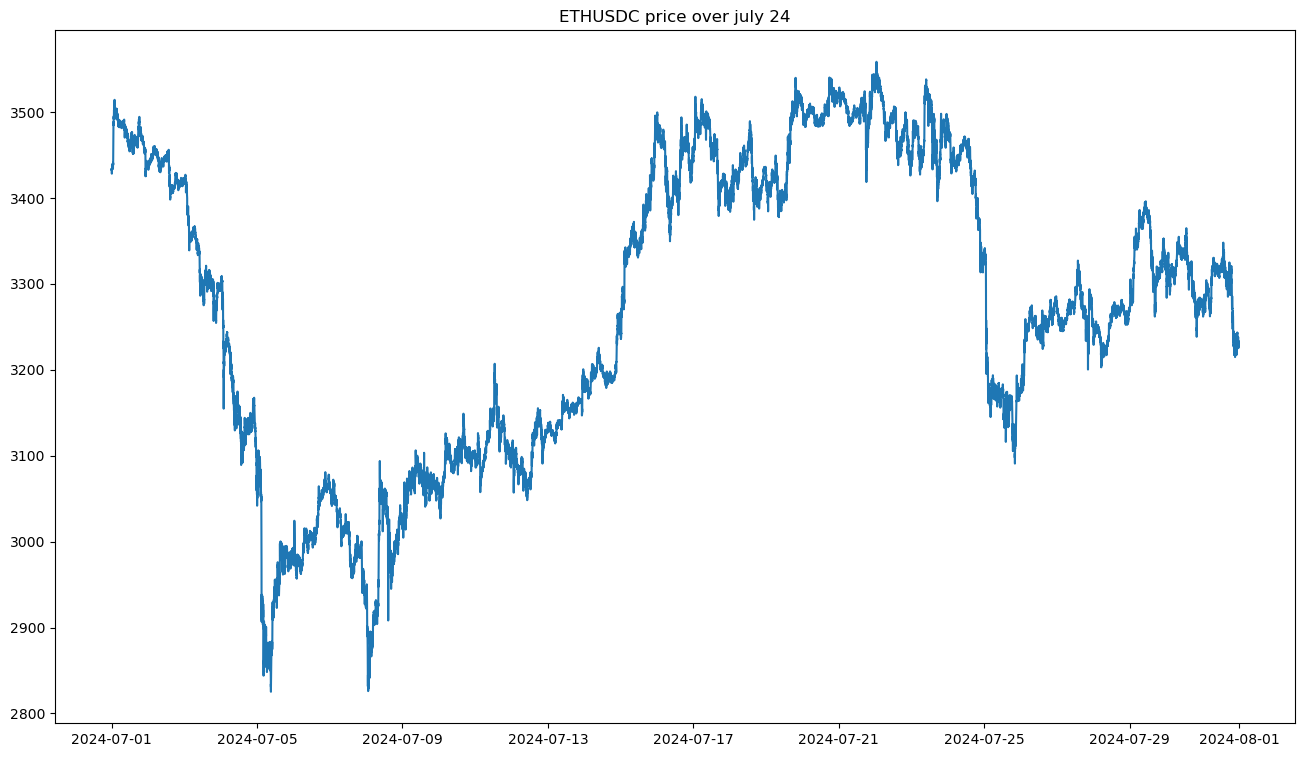

In [23]:
plt.plot(df_july.index.values, df_july['close'].values)
plt.title(pair+' price over july 24')
plt.show()

STANDARD GBM

In [26]:
df_july['log_returns'] = np.log(df_july['close'] / df_july['close'].shift(1))

trading_minutes_per_year = 365 * 24 * 60

log_return_mean = df_july['log_returns'].mean()

mu = log_return_mean * trading_minutes_per_year

log_return_variance = df_july['log_returns'].var()

vol = np.sqrt(log_return_variance * trading_minutes_per_year)

print('mu=',mu)
print('mu_daily=',mu/365)
print('sigma=',vol)
print('sigma_daily=',vol/np.sqrt(365))

mu= -0.7125841163701446
mu_daily= -0.0019522852503291634
sigma= 0.5841391998062597
sigma_daily= 0.030575243130130107


HESTON MODEL

In [27]:
window_size = 60  # 1 hour window
df_july['rolling_std'] = df_july['log_returns'].rolling(window=window_size).std()
df_july['annualized_volatility'] = df_july['rolling_std'] * np.sqrt(trading_minutes_per_year)

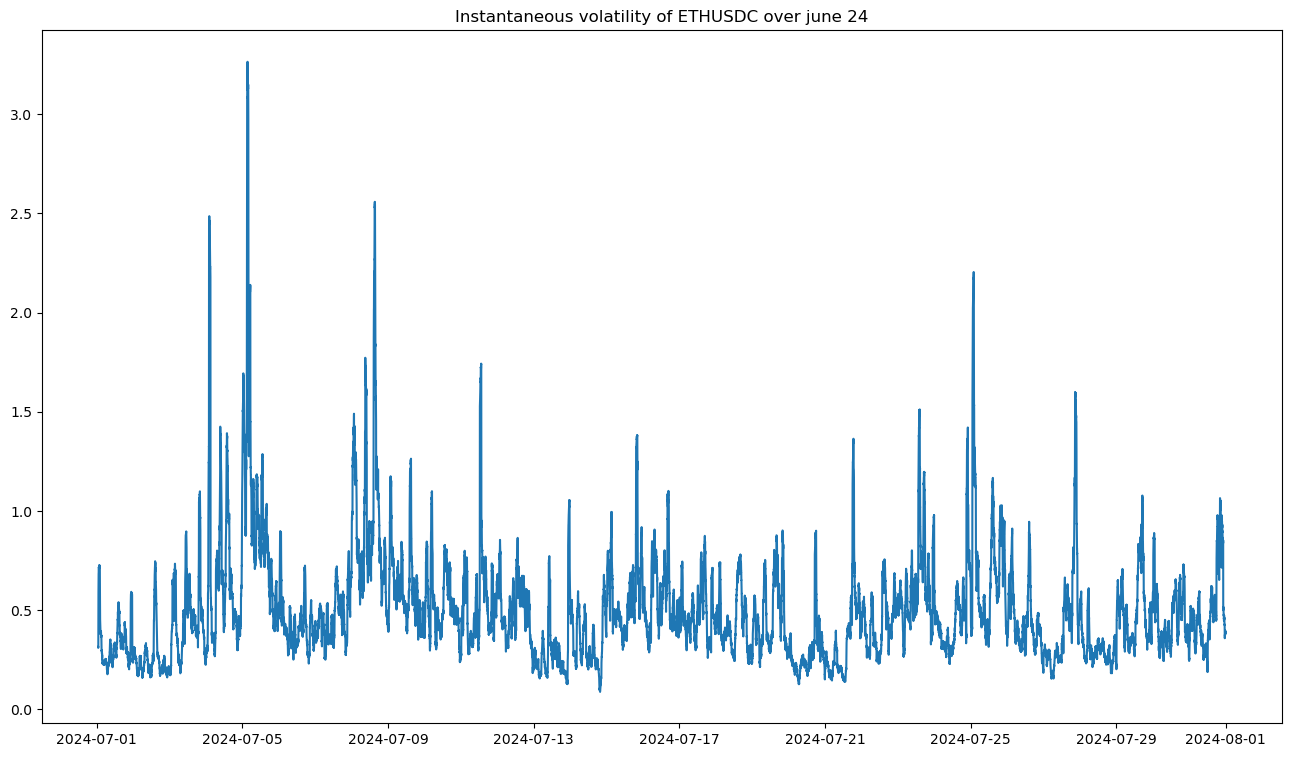

In [28]:
plt.plot(df_july.index.values, df_july['annualized_volatility'].values)
plt.title('Instantaneous volatility of '+pair+' over june 24')
plt.show()

In [29]:
%%time
def objective(trial):
    kappa = trial.suggest_float('kappa', 50., 10000.)
    theta = trial.suggest_float('theta', 0.01, 1.)
    sigma = trial.suggest_float('sigma', 1., 100.)
    params = kappa, theta, sigma
    
    variances = df_july.dropna()['annualized_volatility']**2
    
    dt = 1./trading_minutes_per_year
    
    return heston_log_likelihood(params, variances, dt)

study = optuna.create_study(sampler=TPESampler(seed = 0))
study.enqueue_trial({'kappa': 1000., 'theta': 0.01, 'c': 5.})
study.optimize(objective, n_trials=1000)

[I 2024-08-16 15:45:51,373] A new study created in memory with name: no-name-a7f7b9f5-d073-4dcf-bf25-35be913f8b17
[I 2024-08-16 15:45:51,578] Trial 0 finished with value: -103306.3901166444 and parameters: {'kappa': 1000.0, 'theta': 0.01, 'sigma': 55.33253688880515}. Best is trial 0 with value: -103306.3901166444.
[I 2024-08-16 15:45:51,750] Trial 1 finished with value: -102265.1467709635 and parameters: {'kappa': 7166.134195405574, 'theta': 0.6067357423109274, 'sigma': 54.94343511669279}. Best is trial 0 with value: -103306.3901166444.
[I 2024-08-16 15:45:51,918] Trial 2 finished with value: -109010.30279590903 and parameters: {'kappa': 4265.365253422102, 'theta': 0.6494351719359895, 'sigma': 44.321133915006556}. Best is trial 2 with value: -109010.30279590903.
[I 2024-08-16 15:45:52,088] Trial 3 finished with value: -100992.11097573134 and parameters: {'kappa': 8923.141357781693, 'theta': 0.964026132896019, 'sigma': 38.96071036375199}. Best is trial 2 with value: -109010.30279590903.

[I 2024-08-16 15:45:57,920] Trial 36 finished with value: -102912.34784441844 and parameters: {'kappa': 5706.971650896882, 'theta': 0.6513872085480529, 'sigma': 54.38044610676615}. Best is trial 12 with value: -115830.39686045618.
[I 2024-08-16 15:45:58,096] Trial 37 finished with value: -115771.0864353711 and parameters: {'kappa': 4169.240445329273, 'theta': 0.15590886305087762, 'sigma': 29.903956148808128}. Best is trial 12 with value: -115830.39686045618.
[I 2024-08-16 15:45:58,272] Trial 38 finished with value: -109008.08377175184 and parameters: {'kappa': 3036.5157535527424, 'theta': 0.15484084772677814, 'sigma': 45.61582224675739}. Best is trial 12 with value: -115830.39686045618.
[I 2024-08-16 15:45:58,448] Trial 39 finished with value: 99013.86783816243 and parameters: {'kappa': 4252.61069514434, 'theta': 0.0711793080546031, 'sigma': 8.014272862657691}. Best is trial 12 with value: -115830.39686045618.
[I 2024-08-16 15:45:58,624] Trial 40 finished with value: -90190.41683902351

[I 2024-08-16 15:46:04,276] Trial 72 finished with value: -115897.11014001422 and parameters: {'kappa': 1236.55289431742, 'theta': 0.20593928206804307, 'sigma': 28.190840507379352}. Best is trial 72 with value: -115897.11014001422.
[I 2024-08-16 15:46:04,458] Trial 73 finished with value: -104225.62564947283 and parameters: {'kappa': 1650.6051316695552, 'theta': 0.20753728319538078, 'sigma': 18.72577574609003}. Best is trial 72 with value: -115897.11014001422.
[I 2024-08-16 15:46:04,637] Trial 74 finished with value: -114836.14920371557 and parameters: {'kappa': 790.4649213388493, 'theta': 0.10369089162950962, 'sigma': 34.227857080011624}. Best is trial 72 with value: -115897.11014001422.
[I 2024-08-16 15:46:04,814] Trial 75 finished with value: -115784.9596863594 and parameters: {'kappa': 1109.6088515971378, 'theta': 0.13093190335797383, 'sigma': 27.432074779139935}. Best is trial 72 with value: -115897.11014001422.
[I 2024-08-16 15:46:04,989] Trial 76 finished with value: -113044.739

[I 2024-08-16 15:46:10,610] Trial 108 finished with value: -115346.94815075165 and parameters: {'kappa': 921.380916770522, 'theta': 0.15953579530874995, 'sigma': 25.974070935879794}. Best is trial 97 with value: -115938.63358219659.
[I 2024-08-16 15:46:10,786] Trial 109 finished with value: -108733.8499543328 and parameters: {'kappa': 685.6741169609018, 'theta': 0.2145833046513544, 'sigma': 20.34779215108672}. Best is trial 97 with value: -115938.63358219659.
[I 2024-08-16 15:46:10,961] Trial 110 finished with value: -92610.14804309848 and parameters: {'kappa': 334.60869148279005, 'theta': 0.366919556225096, 'sigma': 74.87525517614662}. Best is trial 97 with value: -115938.63358219659.
[I 2024-08-16 15:46:11,138] Trial 111 finished with value: -115920.68614496865 and parameters: {'kappa': 1651.364253097473, 'theta': 0.24605250394468073, 'sigma': 28.705839374784905}. Best is trial 97 with value: -115938.63358219659.
[I 2024-08-16 15:46:11,313] Trial 112 finished with value: -115926.7352

[I 2024-08-16 15:46:16,971] Trial 144 finished with value: -115294.68767053145 and parameters: {'kappa': 252.58253144838028, 'theta': 0.32339395879558475, 'sigma': 32.8686836149953}. Best is trial 97 with value: -115938.63358219659.
[I 2024-08-16 15:46:17,147] Trial 145 finished with value: -113854.69128643851 and parameters: {'kappa': 53.088866345342694, 'theta': 0.34992757114605827, 'sigma': 23.72125496451663}. Best is trial 97 with value: -115938.63358219659.
[I 2024-08-16 15:46:17,324] Trial 146 finished with value: -115814.0525848606 and parameters: {'kappa': 408.17300364187975, 'theta': 0.2502872769811182, 'sigma': 30.598430865765238}. Best is trial 97 with value: -115938.63358219659.
[I 2024-08-16 15:46:17,500] Trial 147 finished with value: -114255.91598697942 and parameters: {'kappa': 761.2011895099174, 'theta': 0.4185103647240296, 'sigma': 35.699953032470574}. Best is trial 97 with value: -115938.63358219659.
[I 2024-08-16 15:46:17,675] Trial 148 finished with value: -115923.

[I 2024-08-16 15:46:23,379] Trial 180 finished with value: -115704.79458736743 and parameters: {'kappa': 50.47861999782492, 'theta': 0.2458184989219302, 'sigma': 31.20639011522085}. Best is trial 97 with value: -115938.63358219659.
[I 2024-08-16 15:46:23,556] Trial 181 finished with value: -115934.67557376713 and parameters: {'kappa': 1165.4893981776277, 'theta': 0.2758398835833501, 'sigma': 28.9228006104695}. Best is trial 97 with value: -115938.63358219659.
[I 2024-08-16 15:46:23,735] Trial 182 finished with value: -115761.03556780487 and parameters: {'kappa': 1145.4497614113934, 'theta': 0.28664987685227805, 'sigma': 27.28788101765137}. Best is trial 97 with value: -115938.63358219659.
[I 2024-08-16 15:46:23,918] Trial 183 finished with value: -115561.35088880341 and parameters: {'kappa': 1502.6174412184039, 'theta': 0.3365237923173069, 'sigma': 31.822893032974402}. Best is trial 97 with value: -115938.63358219659.
[I 2024-08-16 15:46:24,104] Trial 184 finished with value: -115938.5

[I 2024-08-16 15:46:30,066] Trial 216 finished with value: -115934.60803124127 and parameters: {'kappa': 195.94279022476906, 'theta': 0.3522347265598415, 'sigma': 28.93624056978169}. Best is trial 97 with value: -115938.63358219659.
[I 2024-08-16 15:46:30,252] Trial 217 finished with value: -115879.62948605354 and parameters: {'kappa': 213.64144470508802, 'theta': 0.347082280495087, 'sigma': 30.064996732171473}. Best is trial 97 with value: -115938.63358219659.
[I 2024-08-16 15:46:30,439] Trial 218 finished with value: -115717.36308723774 and parameters: {'kappa': 279.472977565192, 'theta': 0.32150431917965716, 'sigma': 27.089740692918475}. Best is trial 97 with value: -115938.63358219659.
[I 2024-08-16 15:46:30,624] Trial 219 finished with value: -114798.88445648707 and parameters: {'kappa': 63.692122835214946, 'theta': 0.36610130161703247, 'sigma': 24.937008828360227}. Best is trial 97 with value: -115938.63358219659.
[I 2024-08-16 15:46:30,810] Trial 220 finished with value: -115938

[I 2024-08-16 15:46:36,792] Trial 252 finished with value: -115587.86978258393 and parameters: {'kappa': 1201.5809316301777, 'theta': 0.36039219404755946, 'sigma': 26.65783946168432}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:46:36,981] Trial 253 finished with value: -115800.1975397623 and parameters: {'kappa': 826.2494515935033, 'theta': 0.297373628581678, 'sigma': 30.701939384949302}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:46:37,171] Trial 254 finished with value: -115936.11347444684 and parameters: {'kappa': 285.93551144913727, 'theta': 0.33091227224410996, 'sigma': 29.078823953219903}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:46:37,357] Trial 255 finished with value: -115306.4676173759 and parameters: {'kappa': 271.96243882882936, 'theta': 0.3267666897476117, 'sigma': 32.83030544237724}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:46:37,540] Trial 256 finished with value: -1146

[I 2024-08-16 15:46:43,312] Trial 287 finished with value: -115545.81563337657 and parameters: {'kappa': 303.5295133519073, 'theta': 0.20133884406580232, 'sigma': 31.9438025033137}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:46:43,497] Trial 288 finished with value: -115933.95248786025 and parameters: {'kappa': 584.5395405772242, 'theta': 0.15859594239868713, 'sigma': 28.903205349783477}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:46:43,681] Trial 289 finished with value: -113965.42348449174 and parameters: {'kappa': 526.9483115883083, 'theta': 0.1839192546135237, 'sigma': 36.367171767343976}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:46:43,865] Trial 290 finished with value: -115832.23645520718 and parameters: {'kappa': 175.1543749391697, 'theta': 0.15598780116318067, 'sigma': 30.437990231956622}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:46:44,055] Trial 291 finished with value: -115

[I 2024-08-16 15:46:49,858] Trial 322 finished with value: -115417.13282733041 and parameters: {'kappa': 403.3470829298576, 'theta': 0.3283819161183952, 'sigma': 26.133858454252927}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:46:50,050] Trial 323 finished with value: -115938.6068789673 and parameters: {'kappa': 593.819320658113, 'theta': 0.28522107679253783, 'sigma': 29.058560648347363}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:46:50,240] Trial 324 finished with value: -115856.59617486953 and parameters: {'kappa': 528.7515198160423, 'theta': 0.2811703786723334, 'sigma': 30.295383285203016}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:46:50,427] Trial 325 finished with value: -115857.8162973387 and parameters: {'kappa': 301.98463108458316, 'theta': 0.26108399877980476, 'sigma': 27.840065176521122}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:46:50,616] Trial 326 finished with value: -1056

[I 2024-08-16 15:46:56,658] Trial 358 finished with value: -112260.1117231888 and parameters: {'kappa': 704.1677816453639, 'theta': 0.3744284180830703, 'sigma': 22.317594289999743}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:46:56,856] Trial 359 finished with value: -114225.41990295041 and parameters: {'kappa': 370.05856551473335, 'theta': 0.16384569132529184, 'sigma': 35.76864512407439}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:46:57,044] Trial 360 finished with value: -115746.23454470877 and parameters: {'kappa': 823.6038669251152, 'theta': 0.33897129792972297, 'sigma': 31.0190416476097}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:46:57,230] Trial 361 finished with value: -115808.21984752666 and parameters: {'kappa': 1271.803565452333, 'theta': 0.25930694914799685, 'sigma': 27.53605721158892}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:46:57,420] Trial 362 finished with value: -11533

[I 2024-08-16 15:47:03,522] Trial 394 finished with value: -115815.9412961911 and parameters: {'kappa': 3412.140964382769, 'theta': 0.08337331576703118, 'sigma': 28.71771920967205}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:03,725] Trial 395 finished with value: -113597.57082214515 and parameters: {'kappa': 1065.0550343749974, 'theta': 0.3118844607118729, 'sigma': 23.449702435362447}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:03,930] Trial 396 finished with value: -115929.09053881255 and parameters: {'kappa': 403.0318220013041, 'theta': 0.36903012699798277, 'sigma': 29.433293459395635}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:04,135] Trial 397 finished with value: -115714.52640873108 and parameters: {'kappa': 921.3089919203742, 'theta': 0.22372746666613585, 'sigma': 27.071810614905004}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:04,339] Trial 398 finished with value: -11

[I 2024-08-16 15:47:11,764] Trial 430 finished with value: -114318.60796299134 and parameters: {'kappa': 933.7269340626194, 'theta': 0.32065295318661047, 'sigma': 24.250098174601902}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:12,021] Trial 431 finished with value: -109538.97907607643 and parameters: {'kappa': 182.59342979751142, 'theta': 0.24311352829157284, 'sigma': 44.74079841649897}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:12,280] Trial 432 finished with value: -115644.20619853737 and parameters: {'kappa': 654.5855766480596, 'theta': 0.13822439385995475, 'sigma': 26.82176094005859}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:12,536] Trial 433 finished with value: -115821.88570559555 and parameters: {'kappa': 1138.771622204839, 'theta': 0.2735265330322098, 'sigma': 30.53850683868807}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:12,795] Trial 434 finished with value: -115

[I 2024-08-16 15:47:21,073] Trial 466 finished with value: -115524.77115337767 and parameters: {'kappa': 1084.305653515688, 'theta': 0.27782662745439024, 'sigma': 32.03599719342587}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:21,294] Trial 467 finished with value: -105873.81231233334 and parameters: {'kappa': 361.9599985020956, 'theta': 0.3214005677321837, 'sigma': 19.243729109820592}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:21,515] Trial 468 finished with value: -92325.28681704952 and parameters: {'kappa': 777.4457828078191, 'theta': 0.9364060801210845, 'sigma': 75.41183639564619}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:21,736] Trial 469 finished with value: -113261.22837803645 and parameters: {'kappa': 9209.129118468787, 'theta': 0.039357265715348866, 'sigma': 24.94887441286505}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:21,957] Trial 470 finished with value: -11586

[I 2024-08-16 15:47:29,710] Trial 502 finished with value: -115719.09724711062 and parameters: {'kappa': 1153.7355648443186, 'theta': 0.4007380345869835, 'sigma': 27.16119326585078}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:29,951] Trial 503 finished with value: -115160.50343009958 and parameters: {'kappa': 706.4436517441452, 'theta': 0.3702169738900633, 'sigma': 33.30597185441217}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:30,203] Trial 504 finished with value: -115927.68084297585 and parameters: {'kappa': 578.6821997177942, 'theta': 0.3792266807703514, 'sigma': 29.477368978425154}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:30,456] Trial 505 finished with value: -113132.76176900204 and parameters: {'kappa': 953.9054653198934, 'theta': 0.347279365195911, 'sigma': 38.13729402376239}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:30,712] Trial 506 finished with value: -115867.

[I 2024-08-16 15:47:38,569] Trial 538 finished with value: -115934.93905781629 and parameters: {'kappa': 869.2967304656099, 'theta': 0.33310349196786454, 'sigma': 28.790535144256026}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:38,808] Trial 539 finished with value: -115095.56390139063 and parameters: {'kappa': 3834.09410769074, 'theta': 0.33489189395531194, 'sigma': 32.8260348707018}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:39,046] Trial 540 finished with value: -115925.78030885286 and parameters: {'kappa': 785.6657034882996, 'theta': 0.3601491390449034, 'sigma': 28.53971539817386}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:39,283] Trial 541 finished with value: -114823.40087658829 and parameters: {'kappa': 885.5571118012424, 'theta': 0.33715156407792307, 'sigma': 24.96393281035901}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:39,520] Trial 542 finished with value: -115766

[I 2024-08-16 15:47:47,240] Trial 574 finished with value: -115581.81182093285 and parameters: {'kappa': 367.5713372732809, 'theta': 0.2599599724044862, 'sigma': 26.602518133328907}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:47,465] Trial 575 finished with value: -114676.96722382435 and parameters: {'kappa': 542.8699316050455, 'theta': 0.3008118977082817, 'sigma': 34.666632065033134}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:47,689] Trial 576 finished with value: -115930.88391248973 and parameters: {'kappa': 181.84815812547146, 'theta': 0.403565566268572, 'sigma': 28.72805961259234}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:47,914] Trial 577 finished with value: -115818.99181860877 and parameters: {'kappa': 632.8269149284288, 'theta': 0.27279976862246, 'sigma': 30.57789801878603}. Best is trial 221 with value: -115938.94641859819.
[I 2024-08-16 15:47:48,139] Trial 578 finished with value: -115666.4

[I 2024-08-16 15:47:55,264] Trial 610 finished with value: -115358.9925820636 and parameters: {'kappa': 1151.4953915912931, 'theta': 0.3356647775317348, 'sigma': 32.63790904561248}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:47:55,479] Trial 611 finished with value: -115698.90715079289 and parameters: {'kappa': 573.3005757148227, 'theta': 0.2879963631798245, 'sigma': 27.00326603305484}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:47:55,695] Trial 612 finished with value: -115936.32574106999 and parameters: {'kappa': 904.5876574180726, 'theta': 0.3162905869377159, 'sigma': 29.16035248680919}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:47:55,909] Trial 613 finished with value: -115933.13951081848 and parameters: {'kappa': 1086.5998038340422, 'theta': 0.3238008297709613, 'sigma': 28.882585681224445}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:47:56,130] Trial 614 finished with value: -94479.

[I 2024-08-16 15:48:03,066] Trial 646 finished with value: -115908.24141986447 and parameters: {'kappa': 790.9336252268015, 'theta': 0.41377619559479184, 'sigma': 28.310970120718025}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:03,273] Trial 647 finished with value: -115790.6255040447 and parameters: {'kappa': 1199.2079097155656, 'theta': 0.3095098472732087, 'sigma': 30.727826451819052}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:03,480] Trial 648 finished with value: -115157.30013373878 and parameters: {'kappa': 414.1415711176758, 'theta': 0.015121651901111866, 'sigma': 25.582242231440123}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:03,686] Trial 649 finished with value: -89280.65642715957 and parameters: {'kappa': 658.8492697387678, 'theta': 0.35077437305967335, 'sigma': 81.65109817748117}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:03,891] Trial 650 finished with value: -11

[I 2024-08-16 15:48:10,439] Trial 682 finished with value: -114798.368731241 and parameters: {'kappa': 57.454290298407614, 'theta': 0.29851338240176095, 'sigma': 24.937340718937822}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:10,640] Trial 683 finished with value: -115531.02875344933 and parameters: {'kappa': 2174.8054774631937, 'theta': 0.3447667490808361, 'sigma': 26.69489276149926}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:10,844] Trial 684 finished with value: -115648.15084337143 and parameters: {'kappa': 439.5170511858538, 'theta': 0.7011202364841878, 'sigma': 31.494255632107084}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:11,046] Trial 685 finished with value: -115924.97744948481 and parameters: {'kappa': 649.0888904962433, 'theta': 0.3207433388038864, 'sigma': 29.532471970769716}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:11,247] Trial 686 finished with value: -1133

[I 2024-08-16 15:48:18,098] Trial 718 finished with value: -113989.9116644853 and parameters: {'kappa': 639.1369854410875, 'theta': 0.3296607602785528, 'sigma': 36.31749801308146}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:18,297] Trial 719 finished with value: -115452.77860835896 and parameters: {'kappa': 430.9559509011207, 'theta': 0.39538438308156504, 'sigma': 26.222965808573953}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:18,496] Trial 720 finished with value: -115921.70186027563 and parameters: {'kappa': 900.530968851326, 'theta': 0.30851386046287416, 'sigma': 28.465489769759298}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:18,697] Trial 721 finished with value: -115420.06417254754 and parameters: {'kappa': 192.02295912127587, 'theta': 0.26300771170600257, 'sigma': 32.42652970868682}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:18,899] Trial 722 finished with value: -1145

[I 2024-08-16 15:48:25,381] Trial 754 finished with value: -114300.25860730492 and parameters: {'kappa': 216.13964724541873, 'theta': 0.333594575770756, 'sigma': 35.5941050854144}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:25,580] Trial 755 finished with value: -115937.85714035234 and parameters: {'kappa': 940.9267419010162, 'theta': 0.279925187328816, 'sigma': 29.022726431073835}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:25,777] Trial 756 finished with value: -115100.72045876936 and parameters: {'kappa': 1425.2560872805618, 'theta': 0.35940126940660716, 'sigma': 25.497443020797338}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:25,977] Trial 757 finished with value: -115934.81858835401 and parameters: {'kappa': 1065.6973665551113, 'theta': 0.2691283617950111, 'sigma': 29.198046869388524}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:26,175] Trial 758 finished with value: -1152

[I 2024-08-16 15:48:32,530] Trial 790 finished with value: -115938.50979163926 and parameters: {'kappa': 552.3361986216366, 'theta': 0.3771431693852381, 'sigma': 29.117317705802048}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:32,722] Trial 791 finished with value: -115896.71238553463 and parameters: {'kappa': 369.8905170175303, 'theta': 0.40032639269706716, 'sigma': 29.917732235095915}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:32,915] Trial 792 finished with value: -114301.16308557942 and parameters: {'kappa': 202.86047737781374, 'theta': 0.38248296740724025, 'sigma': 24.231016421621927}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:33,108] Trial 793 finished with value: -115342.75540092567 and parameters: {'kappa': 565.0850963031617, 'theta': 0.3760069338026769, 'sigma': 32.71528166007476}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:33,302] Trial 794 finished with value: -11

[I 2024-08-16 15:48:39,631] Trial 826 finished with value: -115763.95385325015 and parameters: {'kappa': 342.9607597745406, 'theta': 0.4469623042851687, 'sigma': 27.283351021869464}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:39,829] Trial 827 finished with value: -115921.39387289884 and parameters: {'kappa': 1148.0999208158705, 'theta': 0.3687163141106359, 'sigma': 29.364830598435283}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:40,027] Trial 828 finished with value: -115383.80061630646 and parameters: {'kappa': 784.0351070296407, 'theta': 0.3446586691851375, 'sigma': 32.569736838136095}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:40,225] Trial 829 finished with value: -115741.043396853 and parameters: {'kappa': 60.931028091669305, 'theta': 0.4087478594969116, 'sigma': 27.213633572975546}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:40,424] Trial 830 finished with value: -1127

[I 2024-08-16 15:48:46,798] Trial 862 finished with value: -114573.25209757678 and parameters: {'kappa': 209.282829298659, 'theta': 0.35115916307791095, 'sigma': 34.925754789079534}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:46,993] Trial 863 finished with value: -115783.52664965326 and parameters: {'kappa': 796.7368040095893, 'theta': 0.40138952927333793, 'sigma': 30.790643749808474}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:47,189] Trial 864 finished with value: -115870.02391994953 and parameters: {'kappa': 634.2666600912506, 'theta': 0.9560121788157735, 'sigma': 28.641420563327525}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:47,382] Trial 865 finished with value: -112602.62969969807 and parameters: {'kappa': 485.1280318277122, 'theta': 0.46067342343822726, 'sigma': 22.57450512959045}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:47,575] Trial 866 finished with value: -115

[I 2024-08-16 15:48:53,481] Trial 897 finished with value: -106095.12218486589 and parameters: {'kappa': 911.8893097107148, 'theta': 0.33367836683744045, 'sigma': 19.319915412848225}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:53,667] Trial 898 finished with value: -108328.6623501448 and parameters: {'kappa': 661.8275476240899, 'theta': 0.26497416205360336, 'sigma': 46.82229382424419}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:53,851] Trial 899 finished with value: -115783.41074616938 and parameters: {'kappa': 1086.4999014104696, 'theta': 0.35441849990139573, 'sigma': 27.417077690215272}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:54,037] Trial 900 finished with value: -115202.25023072324 and parameters: {'kappa': 519.6102055493363, 'theta': 0.3128706061874693, 'sigma': 25.64352090241854}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:48:54,225] Trial 901 finished with value: -115

[I 2024-08-16 15:49:00,136] Trial 933 finished with value: -115182.53194082425 and parameters: {'kappa': 802.2446612244867, 'theta': 0.2538674297477289, 'sigma': 33.23762574103201}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:49:00,330] Trial 934 finished with value: -115259.84756628984 and parameters: {'kappa': 932.6832565475491, 'theta': 0.2796675710346742, 'sigma': 25.767173752612617}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:49:00,531] Trial 935 finished with value: -113372.0597639865 and parameters: {'kappa': 661.4576390987409, 'theta': 0.30655410793436405, 'sigma': 23.22722880116687}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:49:00,744] Trial 936 finished with value: -114657.22443871682 and parameters: {'kappa': 4205.9218615298505, 'theta': 0.571455563018771, 'sigma': 28.952699255232716}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:49:00,947] Trial 937 finished with value: -115713

[I 2024-08-16 15:49:06,831] Trial 969 finished with value: -115251.60265448979 and parameters: {'kappa': 583.0526814332252, 'theta': 0.3367120264312056, 'sigma': 33.019406980654736}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:49:07,013] Trial 970 finished with value: -113734.0479700866 and parameters: {'kappa': 419.44605008919217, 'theta': 0.30181247439025954, 'sigma': 36.88054149435973}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:49:07,195] Trial 971 finished with value: -115851.17061139678 and parameters: {'kappa': 795.4069087822563, 'theta': 0.2707836780210907, 'sigma': 27.76802990465301}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:49:07,376] Trial 972 finished with value: 1605223.4984129881 and parameters: {'kappa': 594.6301322285929, 'theta': 0.34018012856026225, 'sigma': 3.1909671749187716}. Best is trial 607 with value: -115938.97613699132.
[I 2024-08-16 15:49:07,558] Trial 973 finished with value: -11530

CPU times: user 3min 20s, sys: 297 ms, total: 3min 20s
Wall time: 3min 20s


In [30]:
study.best_params

{'kappa': 552.669175700207,
 'theta': 0.35445207396052175,
 'sigma': 29.069709229711677}